# Experiment 1: All Features

## Imports

In [1]:
import os
import numpy as np
import pickle
import copy

from pyaarapsi.vpred.vpred_tools import find_vpr_performance_metrics, find_precision_atR, find_recall_atP
from pyaarapsi.vpred.vpred_factors import find_area_factors, find_peak_factors, find_sensitivity, find_va_factor, find_grad_factor, find_va_factor
from pyaarapsi.vpred.robotmonitor import RobotMonitor, RobotMonitor2D
from pyaarapsi.vpred.robotrun import RobotRun
from pyaarapsi.vpred.robotvpr import RobotVPR

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

from pyaarapsi.core.helper_tools import m2m_dist
import pandas as pd
import seaborn as sns

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
%matplotlib inline

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import scienceplots
plt.style.use('ieee')

## Classes:

In [2]:
class RobotMonitor2D_NetVLAD(RobotMonitor):
    '''
    Robot Monitor using a single SVM with two factors
    '''
    def __init__(self,vpr):
        self.factor1 = find_area_factors(vpr.S,mInd=None)
        self.factor2 = find_peak_factors(vpr.S)[1]
        self.factors = ['Area', 'Mean Trough Value']
        self.Xcal = np.c_[self.factor1,self.factor2]
        self.scaler = StandardScaler()
        self.Xcal_scaled = self.scaler.fit_transform(self.Xcal)
        self.model = svm.SVC(kernel='rbf',
                             C=1,gamma='scale',
                             class_weight='balanced',
                             probability=True)

        self.model.fit(self.Xcal_scaled,vpr.y)

        # Save the training inputs in case they are needed later:
        self.training_y=vpr.y
        self.training_tolerance=vpr.tolerance
        self.training_S=vpr.S
        return
    
    def formX(self,vpr):
        X = np.c_[find_area_factors(vpr.S,mInd=None),find_peak_factors(vpr.S)[1]]
        return self.scaler.transform(X)

class RobotMonitor2D_SALAD(RobotMonitor):
    '''
    Robot Monitor using a single SVM with two factors
    '''
    def __init__(self,vpr):
        self.factor1 = find_sensitivity(vpr.S)[1]
        self.factor2 = find_va_factor(vpr.S)
        self.factors = ['Sensitivity Sum-Diff','VA factor']
        self.Xcal = np.c_[self.factor1,self.factor2]
        self.scaler = StandardScaler()
        self.Xcal_scaled = self.scaler.fit_transform(self.Xcal)
        self.model = svm.SVC(kernel='rbf',
                             C=1,gamma='scale',
                             class_weight='balanced',
                             probability=True)

        self.model.fit(self.Xcal_scaled,vpr.y)

        # Save the training inputs in case they are needed later:
        self.training_y=vpr.y
        self.training_tolerance=vpr.tolerance
        self.training_S=vpr.S
        return
    
    def formX(self,vpr):
        X = np.c_[find_sensitivity(vpr.S)[1],find_va_factor(vpr.S)]
        return self.scaler.transform(X)
    
class RobotMonitor2D_RAW(RobotMonitor):
    '''
    Robot Monitor using a single SVM with two factors
    '''
    def __init__(self,vpr):
        self.factor1 = find_grad_factor(vpr.S)
        self.factor2 = find_va_factor(vpr.S)
        self.factors = ['Grad factor','VA factor']
        self.Xcal = np.c_[self.factor1,self.factor2]
        self.scaler = StandardScaler()
        self.Xcal_scaled = self.scaler.fit_transform(self.Xcal)
        self.model = svm.SVC(kernel='rbf',
                             C=1,gamma='scale',
                             class_weight='balanced',
                             probability=True)

        self.model.fit(self.Xcal_scaled,vpr.y)

        # Save the training inputs in case they are needed later:
        self.training_y=vpr.y
        self.training_tolerance=vpr.tolerance
        self.training_S=vpr.S
        return
    
    def formX(self,vpr):
        X = np.c_[find_grad_factor(vpr.S),find_va_factor(vpr.S)]
        return self.scaler.transform(X)

## Functions

In [3]:
def get_datasets(root) -> dict:
        datasets = {}
        try:
            entry_list = os.scandir(root + "/params/")
        except FileNotFoundError:
            raise Exception("Directory invalid.")
        for entry in entry_list:
            if entry.is_file() and entry.name.startswith('dataset'):
                raw_npz = dict(np.load(entry.path, allow_pickle=True))
                datasets[os.path.splitext(entry.name)[0]] = dict(params=raw_npz['params'].item())
        return datasets

def find_datasets_from_bags(_bags:dict, _folder:str, _other_keys:dict, _try_gen:bool=False):
    _ds_names = { 'Office': 
                    {   'SVM':      {'ref': '', 'qry': ''}, 
                        'Normal':   {'ref': '', 'qry': ''},
                        'Adverse':  {'ref': '',  'qry': ''}},
                    'Campus': 
                    {   'SVM':      {'ref': '',  'qry': ''}, 
                        'Normal':   {'ref': '', 'qry': ''},
                        'Adverse':  {'ref': '', 'qry': ''}}          
                }
    _folder_datasets = get_datasets(_folder)
    for env in ['Office', 'Campus']:
        for cond in ['SVM', 'Normal', 'Adverse']:
            for traverse in ['ref', 'qry']:
                keys = copy.deepcopy(_other_keys)
                keys['bag_name'] = _bags[env][cond][traverse]
                found = False
                for name in _folder_datasets:
                    if _folder_datasets[name]['params'] == keys:
                        _ds_names[env][cond][traverse] = name
                        found = True
                if _try_gen:
                    if not found:
                        global ip
                        if not ('ip' in globals()):
                            from pyaarapsi.vpr_simple.vpr_dataset_tool import VPRDatasetProcessor
                            ip = VPRDatasetProcessor(dataset_params=None, try_gen=True, init_netvlad=True, 
                                                        init_hybridnet=True, init_salad=True, init_apgem=True, cuda=True, 
                                                        use_tqdm=True, autosave=True, ros=False)

                        ip.load_dataset(keys, try_gen=True)
                        _folder_datasets = get_datasets(_folder)
                    for name in _folder_datasets:
                        if _folder_datasets[name]['params'] == keys:
                            _ds_names[env][cond][traverse] = name
                            found = True
                if not found: raise Exception()
    return _ds_names
        
def find_x_m_offset_along_path(vrun,img_index,x,verbose=False):
    # x is in meters (neg for behind, pos for ahead)
    # vrun is a RobotRun object
    # img_index is the index of the image
    if img_index > vrun.imgnum:
        if verbose: print('ERROR find_x_m_offset_along_path: img_index > vrun length');
        return -1
    path = vrun.along_path_distance
    img_location = path[img_index]
    new_location = img_location + x
    if new_location > path[-1]:
        if verbose: print('ERROR find_x_m_offset_along_path: location > path');
        return -1
    if new_location < 0:
        if verbose: print('ERROR find_x_m_offset_along_path: location before beginning of path');
        return -1
    new_index = np.argmin(abs(path - new_location))
    if verbose:
        print('Path length = {0:5.2f} '.format(path[-1]));
        print('Original location along path = {0:5.2f} m @ image index {1}'.format(img_location, img_index));
        print('New location along path = {0:5.2f} m @ image index {1}'.format(new_location, new_index));
    return new_index

def find_values(vpr,q,zone_dist,ref_start):
    gt_ref = vpr.gt_match[q]
    dist_travelled = vpr.ref.along_path_distance[gt_ref] - vpr.ref.along_path_distance[ref_start]
    overshoot = dist_travelled - zone_dist
    return(gt_ref,dist_travelled,overshoot);

# Configuration

In [59]:
FEATURE_TYPE                = 'SALAD' # 'RAW', 'NETVLAD', 'SALAD' # RAW is SAD
DATA_ROOT_DIR               = '/home/claxton/aarapsi_offrobot_ws/src/aarapsi_robot_pack/data/compressed_sets/' # 'data/salad/data_for_helen/NetVLAD features/'
FORCE_GENERATE              = False
SKIP_SAVE                   = False
DO_BIG_MONITOR              = False
DO_TRUNCATE                 = True
SLICE_LENGTHS               = np.array([5.0,10.0,25.0,50.0])
NUM_ITERATIONS              = 50
ASSESS_TOLERANCE            = 0.50
SAMPLE_RATE                 = 5 # 5 or 10

bags        = { 'Office': 
                {   'SVM':      {'ref': 'sim_cw_3', 'qry': 'sim_cw_5'}, 
                    'Normal':   {'ref': 's5_ccw_1', 'qry': 's6_ccw_1'},
                    'Adverse':  {'ref': 's4_cw_1',  'qry': 'lab_adv_2'}},
                'Campus': 
                {   'SVM':      {'ref': 'll_cw_1',  'qry': 'll_cw_3'}, 
                    'Normal':   {'ref': 'run3_fix', 'qry': 'run4_fix'},
                    'Adverse':  {'ref': 'run1_fix', 'qry': 'run5_ccw'}}          
                }

_palette    = {'VPR': '#C5304B', 'SVM': '#16DB93', '$N_P$': '#F29E4C', '$N_R$': '#EFEA5A', 'GT': '#048BA8'}
hue_order   = ['VPR', '$N_P$', '$N_R$','SVM']
set_order   = ['Lab Normal','Lab Adverse','Campus Normal','Campus Adverse']

all_factors = [ "va",
                "grad",
                "agrad",
                "lgrad", "lcoef",
                'area', 'area_norm', 'area_small', 'area_small_norm',
                'uarea', 'uarea_norm', 'uarea_small', 'uarea_small_norm',
                "dlows", "mlows",
                "smean", "sstd",
                "s25th", "smedi", "s75th",
                "IQRskew", "rIQR",
                "rmdist",
                "minima_tmat", "minima_vmat", "minima_teuc", "minima_veuc",
                "sensrange", "senssum", "sensrange_all", "senssum_all",
                "dvcsum", "dvcminsum", "dvcmeansum",
                "minima_valvar", "minima_indvar",
                "minchange", "rngchange",
                "mmperc", "mmdiff"]
bad_factors = [
                "lgrad", "lcoef",
                'area', 'area_norm', 'area_small', 'area_small_norm',
                'uarea', 'uarea_norm', 'uarea_small', 'uarea_small_norm',
                "minchange", "rngchange",
                "sensrange", "senssum", #"sensrange_all", "senssum_all",
                ]

def get_factors(fttype):
    if fttype == 'NETVLAD':
        factors  = ["area", "mlows"]              # Original
        # factors = ['area_norm', 'mlows']          # Bad
        # factors = ['area_small', 'mlows']         # bad
        # factors = ['area_small_norm', 'mlows']    # bad
        # factors  = ["uarea", "mlows"]             # Terrible
        # factors = ['uarea_norm', 'mlows']         # bad
        # factors = ['uarea_small', 'mlows']        # Terrible
        # factors = ['uarea_small_norm', 'mlows']   # bad
        # factors = ['dvcminsum', 'mlows']          # bad
        # factors = ['dvcmeansum', 'mlows']         # bad
        # factors = ['dvcsum', 'mlows']             # OK
        # factors = ['md_mean', 'nvtwo']                # OK
        # factors = ['dvcsum', 'grad']              # ok
        # factors = ['dvcsum', 'senssum_all']       # meh
        # factors = ['dvcminsum', 'grad']           # bad
        # factors = ['senssum_all', 'grad']         # Absolutely terrible
        # factors = ['senssum_all', 'va']           # Absolutely terrible
        # factors = ['senssum_all', 'md_plain']     # Absolutely terrible
        # factors = ['rIQR','smean']                # bad
        # factors = ['mmdiff','sstd']               # eh
        # factors = ['rIQR','IQRskew']              # bad
        # factors = ['dvcsum', 'rmdist']            # meh
        # factors = ['dvcsum', 'md_plain']          # bad
        # factors = ['va','mmdiff']                 # ok
        # factors = ['agrad','va']                  # bad
        # factors = ['rIQR','grad']                 # OK
        # factors = ['rIQR','va']                   # OK
        # factors = ['IQRskew', 'grad']             # maybe
        # factors = ['rIQR', 'grad']                # maybe
        # factors = ['rIQR', 'grad']                # maybe
        # factors = ['va','IQRskew']                # pretty good
        # factors = ['vagradplus', 'IQRskew']       # bad
        # factors = ['vagradmult', 'rIQR']          # bad
        # factors = ['vagradmult', 'IQRskew']       # epic but bad on exp2 :-(
    elif fttype == 'SALAD':
        # factors = ['va', 's75th']
        # factors = ['va', 'agrad']
        # factors  = ["senssum", "va"] # Original
        # factors  = ["grad", "sstd"] # b
        # factors  = ["grad", "s25th"] # b
        # factors  = ["grad", "s75th"] # b
        # factors  = ["grad", "s75th"] # b
        # factors  = ["rmdist", "va"] # maybe
        # factors  = ["rmdist", "grad"] # b
        # factors  = ["rmdist", "va"] # maybe
        factors  = ["senssum_all", "va"] # good!
    elif fttype == 'RAW':
        factors = ['grad', 'va'] # Original
        # factors = ['smedi', 'va'] # actually beats original at times, probably equivalent
        # factors = ['grad', 's25th'] # ok
    return np.sort(factors)

# Generate Data

## actual data generation

In [60]:
other_keys_dictionary = dict(   bag_name=None, npz_dbp="/data/compressed_sets", bag_dbp="/data/rosbags", odom_topic="/odom/true", 
                                img_topics=["/ros_indigosdk_occam/image0/compressed"], sample_rate=SAMPLE_RATE, 
                                ft_types=[FEATURE_TYPE], img_dims=[64,64], filters='')

ds_names    = find_datasets_from_bags(_bags=bags, _folder=DATA_ROOT_DIR, _other_keys=other_keys_dictionary)

if SAMPLE_RATE == 5:
    # Note that NetVLAD and SALAD have half the reference truncation value here compared with the original SAD exp1
    truncations = { 'RAW':       [629, 689, 1593, 1826], #[650, 640, 1500, 1350],
                    'NETVLAD':   [629, 689, 1593, 1826], #[650, 640, 1500, 1350],
                    'SALAD':     [629, 689, 1593, 1826]} #[650, 640, 1500, 1350]}
    ROBOT_TOLERANCE = -0.10#-0.20 # I changed this from 10cm to 20cm to accomodate the larger gap distances due sampling at 5Hz vs 10Hz
elif SAMPLE_RATE == 10:
    truncations = { 'RAW':       [1051, 1131, 2529, 2905], #[1300, 1280, 3000, 2700], 
                    'NETVLAD':   [1051, 1131, 2529, 2905], #[1300, 1280, 3000, 2700],
                    'SALAD':     [1051, 1131, 2529, 2905]} #[1300, 1280, 3000, 2700]}
    ROBOT_TOLERANCE = -0.10#-0.10
else:
    raise Exception('Bad sample rate.')

MONITOR_CLASS = None
if DO_BIG_MONITOR:
    from big_monitor import fused_robotmonitor
    MONITOR_CLASS = lambda *args, **kwargs: fused_robotmonitor
else:
    MONITOR_CLASS = lambda vpr: RobotMonitor2D(vpr=vpr, _factors_in=get_factors(FEATURE_TYPE))

    # if FEATURE_TYPE == 'NETVLAD':
    #     MONITOR_CLASS = RobotMonitor2D_NetVLAD
    # elif FEATURE_TYPE == 'SALAD':
    #     MONITOR_CLASS = RobotMonitor2D_SALAD
    # elif FEATURE_TYPE == 'RAW':
    #     MONITOR_CLASS = RobotMonitor2D_RAW

file_name = "pickle_data/experiment_1_data_" + FEATURE_TYPE + "_sr" + str(SAMPLE_RATE) + "hz_" + get_factors(FEATURE_TYPE)[0] + "_" + get_factors(FEATURE_TYPE)[1] + ".obj"

# # To perform no truncation:
# truncations = { 'RAW':       [5000, 5000, 5000, 5000], #[1300, 1280, 3000, 2700], 
#                 'NETVLAD':   [5000, 5000, 5000, 5000], #[1300, 1280, 3000, 2700],
#                 'SALAD':     [5000, 5000, 5000, 5000]} 

try:
    if FORCE_GENERATE: raise Exception()
    
    with (open(file_name, "rb")) as openfile:
        DATA_CONTAINER = pickle.load(openfile)

    print('Loading datasets ...')
    datasets    = DATA_CONTAINER['datasets']

    print('Loading data ...')
    data        = DATA_CONTAINER['data']

    print('Loading vpr ...')
    vpr         = DATA_CONTAINER['vpr']

    monitors=np.empty(4,dtype='object')
    for m,row in vpr.iterrows():
        monitors[m]=MONITOR_CLASS(row.train)

except:
    if FORCE_GENERATE: print('Generating data ...')
    else: print('Data failed to load; attempting to generate ...')
    DATA_CONTAINER = {}

    datasets = pd.DataFrame(columns=np.array(['environment','adversity','run1','run2','run3','run4','ref_last_image','train_ref','train_qry','test_ref','test_qry']));
    datasets.loc[0,:]=['Lab',   True,  ds_names['Office']['SVM']['ref'], ds_names['Office']['SVM']['qry'], ds_names['Office']['Adverse']['ref'], ds_names['Office']['Adverse']['qry'],  truncations[FEATURE_TYPE][0], None, None, None, None]
    datasets.loc[1,:]=['Lab',   False, ds_names['Office']['SVM']['ref'], ds_names['Office']['SVM']['qry'], ds_names['Office']['Normal']['ref'],  ds_names['Office']['Normal']['qry'],   truncations[FEATURE_TYPE][1], None, None, None, None]
    datasets.loc[2,:]=['Campus',True,  ds_names['Campus']['SVM']['ref'], ds_names['Campus']['SVM']['qry'], ds_names['Campus']['Adverse']['ref'], ds_names['Campus']['Adverse']['qry'],  truncations[FEATURE_TYPE][2], None, None, None, None]
    datasets.loc[3,:]=['Campus',False, ds_names['Campus']['SVM']['ref'], ds_names['Campus']['SVM']['qry'], ds_names['Campus']['Normal']['ref'],  ds_names['Campus']['Normal']['qry'],   truncations[FEATURE_TYPE][3], None, None, None, None]

    datasets['train_ref']=datasets['train_ref'].astype('object')
    datasets['train_qry']=datasets['train_qry'].astype('object')
    datasets['test_ref']=datasets['test_ref'].astype('object')
    datasets['test_qry']=datasets['test_qry'].astype('object')

    vprcols=np.array(['env','adv','train','test','cl_metrics','bl_metrics','svm_array','matchR_R', 'matchR_P', 'matchR_d','matchP_R', 'matchP_P', 'matchP_d','dist'])
    vpr=pd.DataFrame(index=np.arange(len(datasets)),columns=vprcols)

    print('\tGenerating datasets...')

    for j,row in datasets.iterrows():

        row=datasets.iloc[j,:]
        print('\t\tDataset {0}:  {1} {2}'.format(j, row.environment,'Adverse' if row.adversity else 'Normal'))

        runs=np.empty(4,dtype=RobotRun)

        for k,run_name in enumerate(['run1','run2','run3','run4']):
        
            set_name = datasets.loc[j,run_name]
            npz_path = DATA_ROOT_DIR + set_name + '.npz'
            npz_data = np.load(npz_path, allow_pickle=True)
            run_data = npz_data['dataset'].item()
            
            features=run_data[FEATURE_TYPE]
            
            runs[k]=RobotRun(folder="",npz_setup=True)
            runs[k].set_features(features,size=64)
            runs[k].set_xy(np.c_[run_data['px'],run_data['py']])
            runs[k].set_yaw(np.degrees(run_data['pw']))
            runs[k].set_sample_rate=npz_data['params'].item()['sample_rate']
            runs[k].set_description(npz_data['params'].item()['bag_name'])
                
        if row.environment == 'Campus':
            TOLERANCE = 1
        elif row.environment == 'Lab':
            TOLERANCE = 0.5

        datasets.at[j,'train_ref']=runs[0]
        datasets.at[j,'train_qry']=runs[1]
        datasets.at[j,'test_ref']=runs[2]
        datasets.at[j,'test_qry']=runs[3]
        
        trainvpr=RobotVPR(datasets.train_ref[j],datasets.train_qry[j],norm=False)
        trainvpr.assess_performance(TOLERANCE,'m',verbose=False)

        if DO_TRUNCATE:
            datasets.at[j,'test_ref'].truncate(0,datasets.ref_last_image[j], verbose=False)
            rawtestvpr=RobotVPR(datasets.test_ref[j],datasets.test_qry[j],norm=False)
            gt_match_copy = copy.deepcopy(rawtestvpr.gt_match)
            gt_match_copy[0:int(gt_match_copy.shape[0]/2)] = 0 # because, otherwise it can (and will) match to the start instead (resulting in ridiculously big truncations)
            qry_last_image = np.argmin(abs(gt_match_copy-datasets.ref_last_image[j]))
            datasets.at[j,'test_qry'].truncate(0,qry_last_image, verbose=False)
        
        testvpr=RobotVPR(datasets.test_ref[j],datasets.test_qry[j],norm=False)
        testvpr.assess_performance(TOLERANCE,'m',verbose=False)

        monitor=MONITOR_CLASS(trainvpr)

        metric_names = np.array(['p','r','tp','fp','tn','fn','d'])
        cl_metrics=pd.Series(data=trainvpr.compute_cl_PRcurve_metrics(monitor.predict_quality(trainvpr)),index=metric_names)
        bl_metrics=pd.Series(data=trainvpr.compute_PRcurve_metrics(),index=metric_names)
        
        matchR_R, matchR_P, matchR_d=find_precision_atR(bl_metrics.p,bl_metrics.r,cl_metrics.r[-1],verbose=False)
        matchP_R, matchP_P, matchP_d=find_recall_atP(bl_metrics.p,bl_metrics.r,cl_metrics.p[-1],verbose=False)
        
        # This is needed to find the start/end query numbers for each start/end ref number in loop below
        d=m2m_dist(testvpr.ref.xy,testvpr.qry.xy)
        
        testvpr.ref.find_along_path_distances()
        testvpr.qry.find_along_path_distances()
        
        svm_array=np.empty(4,dtype='object')
        svm_array[0]=testvpr.ALL_TRUE
        svm_array[1]=monitor.predict_quality(testvpr)
        svm_array[2]=testvpr.best_match_S < bl_metrics.d[matchP_d]
        svm_array[3]=testvpr.best_match_S < bl_metrics.d[matchR_d]
        svm_dict={0:'no_filter', 1:'SVM', 2:'naive_threshold_P', 3:'naive_threshold_R'}

        vpr.iloc[j,:]=np.array([row.environment,row.adversity,trainvpr,testvpr,cl_metrics,bl_metrics,svm_array,matchR_R,matchR_P,matchR_d,matchP_R, matchP_P, matchP_d,d],dtype='object')

    print('\t\tDataset generation completed.')

    print('\tPerforming experiments...')

    monitors=np.empty(4,dtype='object')
    for m,row in vpr.iterrows():
        monitors[m]=MONITOR_CLASS(row.train)

    cols=np.array(['i','q','ref_start','ref_end','qry_start','qry_end','bm','gt_ref','zone_dist','dist_travelled','overshoot','goal_found','Using_SVM','bm_loc',
                'ref_start_with_buffer','ref_end_with_buffer','slice_length','environment','adversity','mission_impossible'])
    data = pd.DataFrame(columns=cols)

    for j,row in tqdm(vpr.iterrows()):

        print('\t\tDataset {0}:  {1} {2}'.format(j, row.env,'Adverse' if row.adv else 'Normal'))
        for slice_length in SLICE_LENGTHS:     
            for i in range(NUM_ITERATIONS):

                mission_impossible = True
                max_attempts = 10
                tries = 0

                while mission_impossible and tries < max_attempts:
                
                    ref_start = np.random.randint(100,find_x_m_offset_along_path(row.test.ref,row.test.ref.imgnum-1,-(slice_length-ROBOT_TOLERANCE),verbose=False));
                    ref_end = find_x_m_offset_along_path(row.test.ref,ref_start,slice_length,verbose=False) 
                    qry_start = np.argmin(row.dist[ref_start,:])
                    qry_end = np.argmin(row.dist[ref_end,:])
            
                    ref_start_with_buffer = find_x_m_offset_along_path(row.test.ref,ref_start,-1 * ASSESS_TOLERANCE,verbose=False)
                    ref_end_with_buffer   = find_x_m_offset_along_path(row.test.ref,ref_end,-1 * ROBOT_TOLERANCE,verbose=False)
                    
                    qry_end_pre   = find_x_m_offset_along_path(row.test.qry,qry_end,-1 * ASSESS_TOLERANCE,verbose=False)
                    qry_end_post  = find_x_m_offset_along_path(row.test.qry,qry_end,ASSESS_TOLERANCE,verbose=False)
                    
                    zone_dist = row.test.ref.along_path_distance[ref_end]-row.test.ref.along_path_distance[ref_start]

                    mission_impossible = (row.test.y[qry_end_pre:qry_end_post+1].sum() == 0)
                    tries += 1
                
                for svm_technique, svm_output in enumerate(row.svm_array):
                    #bm = -1
                    goal_found = False
                    q = -1
                    for q in np.arange(qry_start,row.test.qry.imgnum):  # start at beginning of zone through all remaining qrys
                        bm = row.test.best_match[q]
                        if (((bm >= ref_end_with_buffer) | (bm < ref_start_with_buffer)) & (svm_output[q] == True)):
                            goal_found = True
                            break
                    if q == -1: raise Exception('Unsafe q value; experiment was somehow skipped')

                    if goal_found == True:
                        bm_loc          = row.test.ref.along_path_distance[bm]
                        gt_ref          = row.test.gt_match[q]
                        dist_travelled  = row.test.qry.along_path_distance[q] - row.test.qry.along_path_distance[qry_start]
                        overshoot       = dist_travelled - zone_dist
                    else:
                        bm_loc          = -1
                        gt_ref          = -1
                        dist_travelled  = -1
                        overshoot       = -1

                    data.loc[len(data),:]=np.array([i,q,ref_start,ref_end,qry_start,qry_end,bm,gt_ref,zone_dist,dist_travelled,overshoot,goal_found,svm_technique,
                                            bm_loc,row.test.ref.along_path_distance[ref_start_with_buffer],row.test.ref.along_path_distance[ref_end_with_buffer],
                                            slice_length,row.env,row.adv,mission_impossible],dtype='object')
    print('\t\tExperiments completed.')
    print('\tPerforming data post-processing...')
    for name in ['goal_found','adversity']:
        data[name]=data[name].astype('bool')
    for name in ['overshoot','zone_dist','dist_travelled']:
        data[name]=data[name].astype('float')
    for name in ['i','q','ref_start','ref_end','qry_start','qry_end','gt_ref']:
        data[name]=data[name].astype('int64')
    for name in ['bm']:
        data[name]=data[name].astype('int64')

    data['environment']=data['environment'].astype('category')
    data['perc_complete']= (data.dist_travelled / data.zone_dist) * 100
    data['Using_SVM'] = data['Using_SVM'].astype('category')
    data['Using_SVM'] = data['Using_SVM'].map(svm_dict)
    # campus run: mission success if < 1m overshoot/undershoot
    data['mission_complete']= abs(data.overshoot) < 1
    # lab run: mission success if < 0.5m overshoot/undershoot

    lab_success=abs(data.loc[data.environment=='Lab','overshoot']) < ASSESS_TOLERANCE
    data.loc[data.environment=='Lab','mission_complete']=lab_success

    data['mission_complete']=data.mission_complete & data.goal_found
    data['abs_overshoot']=abs(data.overshoot)
    data.mission_complete.describe()

    data['condition']=None
    for i,row in data.iterrows():
        if row.adversity == True:
            adv_str = ' Adverse'
        else:
            adv_str = ' Normal'
        cond = row.environment + adv_str
        data.iloc[i,-1]=cond

    data['filter']=None
    data.loc[data.Using_SVM=='no_filter','filter']='VPR'
    data.loc[data.Using_SVM=='SVM','filter']='SVM'
    data.loc[data.Using_SVM=='naive_threshold_P','filter']='$N_P$'
    data.loc[data.Using_SVM=='naive_threshold_R','filter']='$N_R$'
    
    print('\t\tDone.')

    DATA_CONTAINER['datasets']  = datasets
    DATA_CONTAINER['vpr']       = vpr
    DATA_CONTAINER['data']      = data
    
    if not SKIP_SAVE:
        print('\tSaving dataset ...')
        file_obj = open(file_name, 'wb')
        pickle.dump(DATA_CONTAINER,file_obj)
        file_obj.close()
        
print('Data Ready.')

Loading datasets ...
Loading data ...
Loading vpr ...
Data Ready.


In [61]:
# # Find truncation indices; run with no truncation 
# crop_inds = []
# for ind in range(4):
#     crop_index = np.argmin(np.abs(vpr.test[ind].ref.along_path_distance - (vpr.test[ind].ref.along_path_distance[-1] - 5)))
#     crop_inds.append(crop_index)

# print(crop_inds)

# Single Feature

## Plots

### Box plot

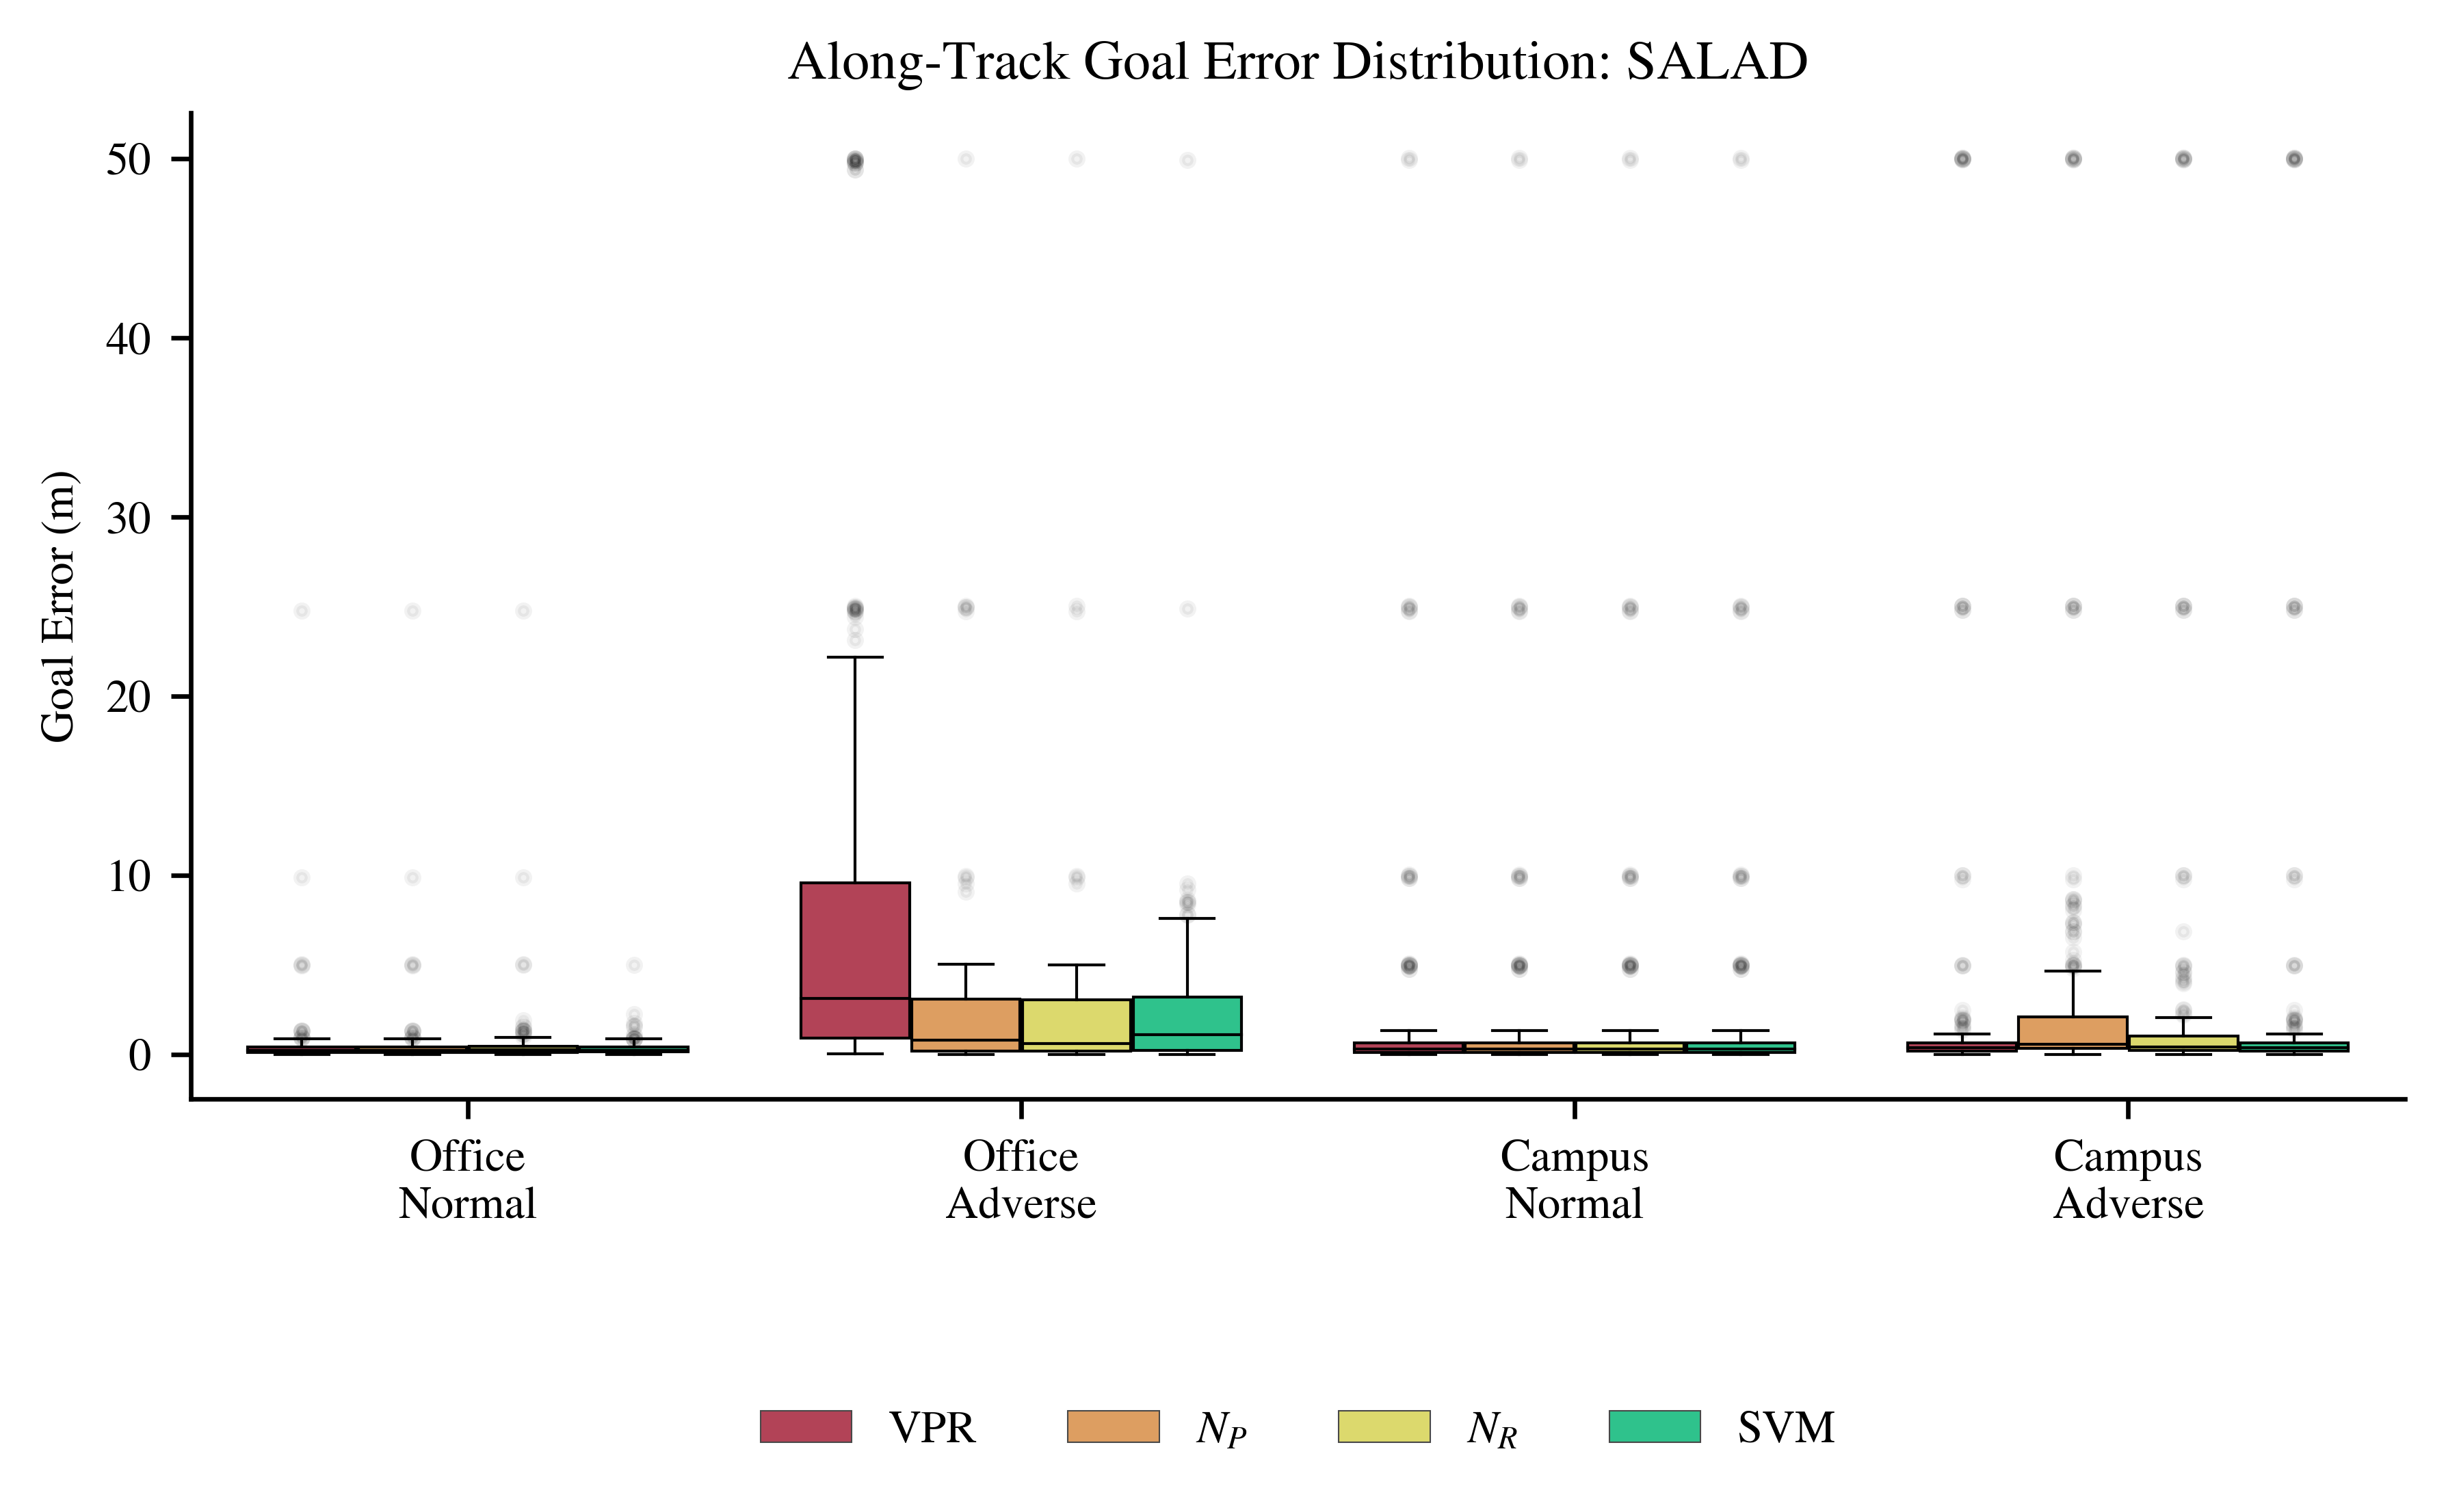

In [62]:
f=sns.catplot(data=data[(data.goal_found==True)],x='condition',y='abs_overshoot',kind='box',hue='filter',
               height=3, aspect=6/3, legend=False,palette=_palette,hue_order=hue_order,order=set_order,
             linewidth=0.5, width=0.8,
                                                 flierprops=dict(alpha=.05, marker='.', markersize=4, markeredgecolor='k', markerfacecolor='k'),
                                                 capprops=dict(color='k'),
                                                 boxprops=dict(edgecolor='k'), whiskerprops=dict(color='k'), medianprops=dict(color='k'))
f.set_xticklabels(['Office\nNormal','Office\nAdverse','Campus\nNormal','Campus\nAdverse']);#,(rotation=45, ha='right')
f.set(ylabel='Goal Error (m)',xlabel="",title="Along-Track Goal Error Distribution: " + FEATURE_TYPE)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),ncols=4,title='',frameon=False)
#plt.ylim([0,10])
# plt.savefig('exp1_loc_error.pdf',dpi=300,facecolor='white',bbox_inches='tight')

### Bar plot

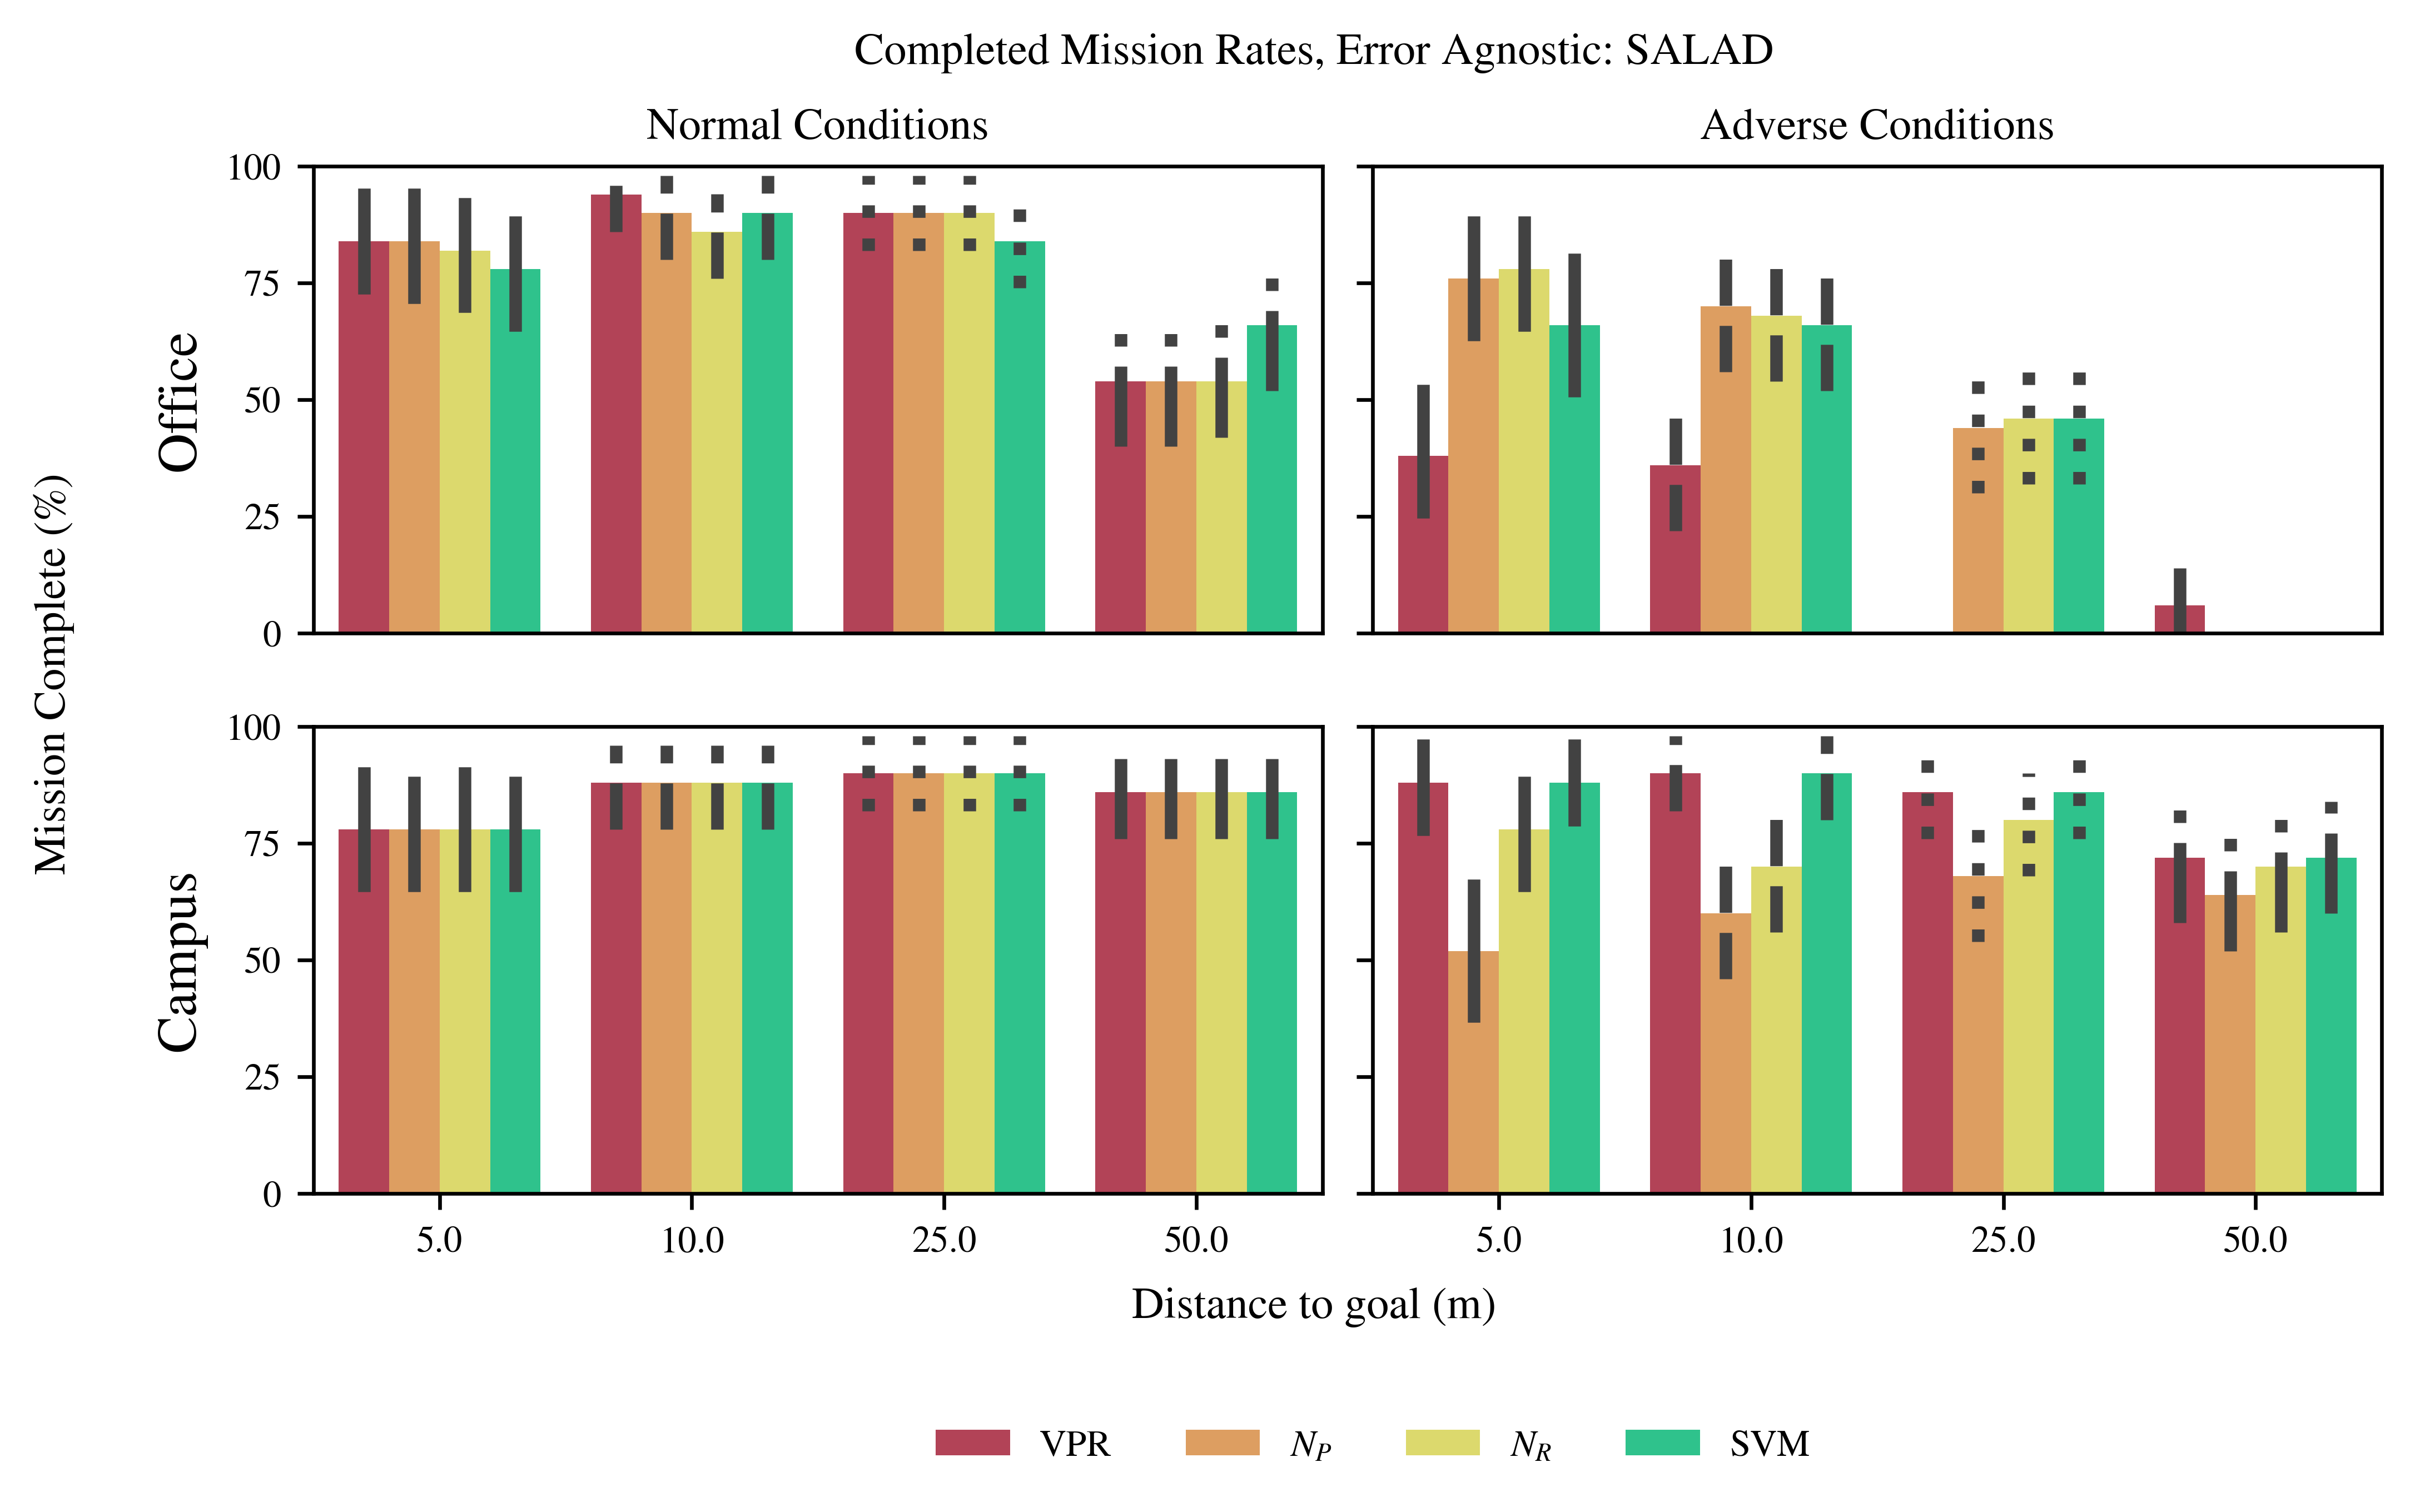

In [63]:
palette='viridis'
fig,ax=plt.subplots(2,2,figsize=(8,4),sharex=True,sharey=True)
f1=sns.barplot(data=data[(data.environment=='Lab') & (data.adversity==False) & (data.mission_impossible==False)],
               x='slice_length',y='mission_complete',hue='filter',palette=_palette,ax=ax[0,0],hue_order=hue_order,
              linewidth=0.5, width=0.8)
f2=sns.barplot(data=data[(data.environment=='Lab') & (data.adversity==True) & (data.mission_impossible==False)],
               x='slice_length',y='mission_complete',hue='filter',palette=_palette,ax=ax[0,1],hue_order=hue_order,
              linewidth=0.5, width=0.8)
f3=sns.barplot(data=data[(data.environment=='Campus') & (data.adversity==False) & (data.mission_impossible==False)],
               x='slice_length',y='mission_complete',hue='filter',palette=_palette,ax=ax[1,0],hue_order=hue_order,
              linewidth=0.5, width=0.8)
f4=sns.barplot(data=data[(data.environment=='Campus') & (data.adversity==True) & (data.mission_impossible==False)],
               x='slice_length',y='mission_complete',hue='filter',palette=_palette,ax=ax[1,1],hue_order=hue_order,
              linewidth=0.5, width=0.8)
ax[0,0].set_ylabel('Office',fontsize=12)
ax[1,0].set_ylabel('Campus',fontsize=12)
ax[1,0].set_xlabel('')
ax[1,1].set_xlabel('')
ax[0,0].legend_.remove()
ax[0,1].legend_.remove()
ax[1,0].legend_.remove()
f1.set(xlabel=None,ylim=(0,1),yticks=[0,0.25,0.5,0.75,1.0],yticklabels=[0,25,50,75,100]);
f2.set(xlabel=None, ylabel=None)
f4.set(ylabel=None)
f1.tick_params(bottom=False)  # remove the ticks
f2.tick_params(bottom=False)  # remove the ticks
#ax[1,1].legend_.remove()

fig.supylabel('Mission Complete (%)')
fig.supxlabel('Distance to goal (m)')
fig.suptitle('Completed Mission Rates, Error Agnostic: ' + FEATURE_TYPE)

#fig.suptitle('Mission Completion for Various Filtering Techniques');
f1.set(title='Normal Conditions')
f2.set(title='Adverse Conditions')

legend1=ax[1,1].legend(loc='lower center', bbox_to_anchor=(0, -0.65),ncols=4, frameon=False,title='')
                      #labels=['No Filter','SVM','Naive Threshold (match P)','Naive Threshold (match R)'])

plt.subplots_adjust(wspace=0.05)
#plt.savefig("exp1_summary.pdf",dpi=300,facecolor="white",bbox_inches='tight')


## Tables

In [64]:
# data[(data.goal_found==True)].groupby(['condition','filter']).abs_overshoot.describe()

Find key results for whole dataset

In [65]:
# data[(data.goal_found==True)].groupby(['filter']).abs_overshoot.describe()

In [66]:
# print('Train:')
# find_vpr_performance_metrics(monitors[0].predict_quality(vpr.train[0]),vpr.train[0].y,vpr.train[0].ALL_TRUE,verbose=True)
# find_vpr_performance_metrics(monitors[2].predict_quality(vpr.train[2]),vpr.train[2].y,vpr.train[2].ALL_TRUE,verbose=True)
# print('Test:')
# find_vpr_performance_metrics(monitors[0].predict_quality(vpr.test[0]),vpr.test[0].y,vpr.test[0].ALL_TRUE,verbose=True)
# find_vpr_performance_metrics(monitors[1].predict_quality(vpr.test[1]),vpr.test[1].y,vpr.test[1].ALL_TRUE,verbose=True)
# find_vpr_performance_metrics(monitors[2].predict_quality(vpr.test[2]),vpr.test[2].y,vpr.test[2].ALL_TRUE,verbose=True)
# find_vpr_performance_metrics(monitors[3].predict_quality(vpr.test[3]),vpr.test[3].y,vpr.test[3].ALL_TRUE,verbose=True);

# All Features

## Data

In [67]:
_df_features = {}
for _ft_type in ['RAW', 'NETVLAD', 'SALAD']:
    file_name = "pickle_data/experiment_1_data_" + _ft_type + "_sr" + str(SAMPLE_RATE) + "hz_" + get_factors(_ft_type)[0] + "_" + get_factors(_ft_type)[1] + ".obj"


    with (open(file_name, "rb")) as openfile:
        DATA_CONTAINER = pickle.load(openfile)

    _df = DATA_CONTAINER['data']
    _df['vprfeaturetype'] = _ft_type
    _df['svmfactor1type'] = get_factors(_ft_type)[0]
    _df['svmfactor2type'] = get_factors(_ft_type)[1]

    _df_features[_ft_type] = _df

df_features = pd.concat([_df_features[i] for i in _df_features.keys()])

## Plots

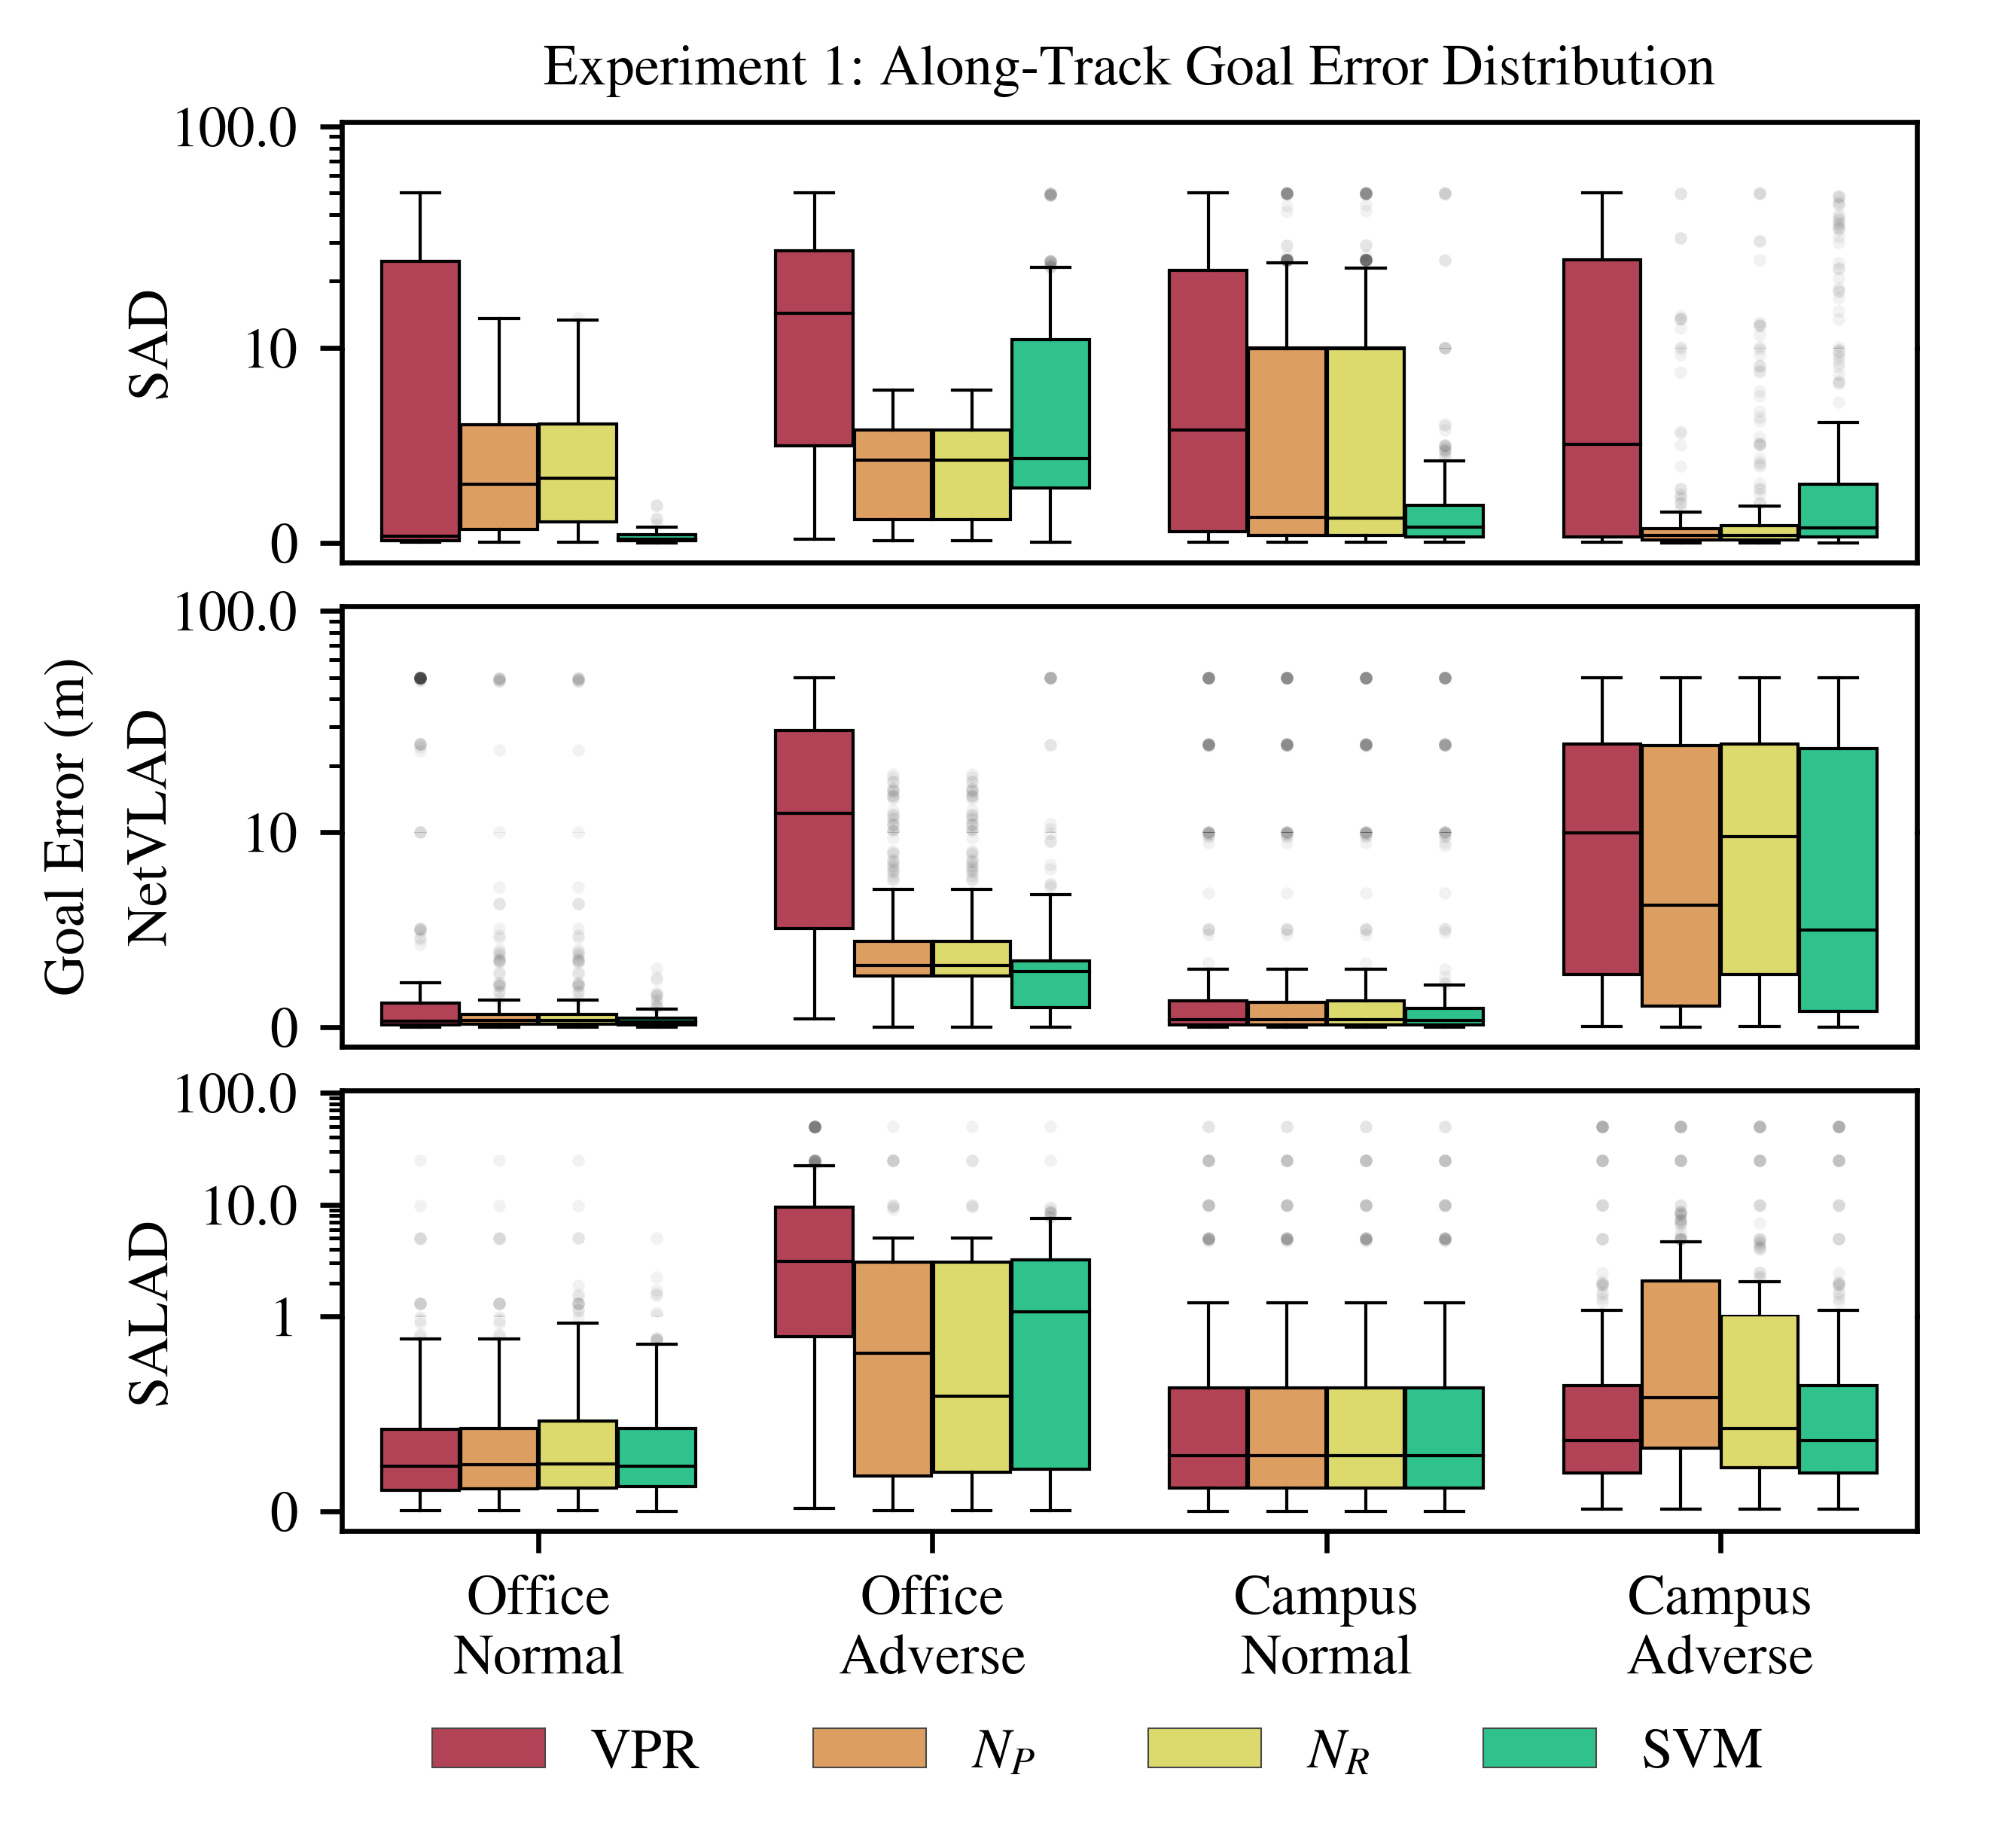

In [68]:
# For some reason, this plot breaks in Seaborn v0.13.0
# pip install seaborn==0.12.2; pgrep python | xargs kill -9
# then rerun script.

if True: # for code folding :-)
    def make_split_axes_y_linlog(_fig, _axes, _lims, _plotter, _logplotter=None, _subplot=111, _size=1):
        # Configure base axis as linear:
        _axes.set_yscale('linear')
        _axes.set_ylim((_lims[0], _lims[1]))

        # Generate, attach, and configure a secondary logarithmic axis:
        _axes_divider = make_axes_locatable(_axes)
        _axeslog = _axes_divider.append_axes("top", size=_size, pad=0, sharex=_axes)
        _axeslog.set_yscale('log')
        _axeslog.set_ylim((_lims[1]+0.001*_lims[1], _lims[2])) # add a miniscule amount to the start to prevent duplicated axis labels

        # Plot the data in both axes:
        _plotter(_axes)
        _plotter(_axeslog)

        # Hide middle bar:
        _axes.spines['top'].set_visible(False)
        _axeslog.spines['bottom'].set_visible(False)
        _axeslog.xaxis.set_visible(False)

        # Create an invisible frame to provide overarching anchor positions for axis labels:
        _axes.set_ylabel('')
        _axes.set_xlabel('')
        _axeslog.set_ylabel('')
        _axeslog.set_xlabel('')

        _axeslog.get_legend().set_visible(False)
        _axes.get_legend().set_visible(False)

        return _axeslog

    _s = 4.5/4.0

    fig_m1, axes_m1         = plt.subplots(3,1,figsize=(4*_s,_s*1.2*3), sharex=True)

    axes_m1_plotter         = lambda ft_type, ax: sns.boxplot(data=df_features[(df_features['vprfeaturetype']==ft_type) & (df_features.goal_found==True)], 
                                                    y='abs_overshoot',x='condition',hue='filter',ax=ax, palette=_palette,
                                                    hue_order=hue_order, order=set_order, linewidth=0.5, width=0.8,
                                                    flierprops=dict(alpha=.05, marker='.', markersize=4, markeredgecolor='none', markerfacecolor='k'),
                                                    capprops=dict(color='k'),
                                                    boxprops=dict(edgecolor='k'), whiskerprops=dict(color='k'), medianprops=dict(color='k'))

    logscale = True
    _formatter = ticker.FormatStrFormatter("%0.1f")
    if logscale:
        axes_m1log0             = make_split_axes_y_linlog(fig_m1, axes_m1[0], [-1, 10, 105], lambda ax: axes_m1_plotter('RAW', ax), _size=0.5)
        axes_m1log1             = make_split_axes_y_linlog(fig_m1, axes_m1[1], [-1, 10, 105], lambda ax: axes_m1_plotter('NETVLAD', ax), _size=0.5)
        axes_m1log2             = make_split_axes_y_linlog(fig_m1, axes_m1[2], [-0.1, 1, 105], lambda ax: axes_m1_plotter('SALAD', ax), _size=0.5)
        axes_m1log0.yaxis.set_major_formatter(_formatter)
        axes_m1log1.yaxis.set_major_formatter(_formatter)
        axes_m1log2.yaxis.set_major_formatter(_formatter)
        axes_m1log0.tick_params(axis='both', which='both', labelsize=9)
        axes_m1log1.tick_params(axis='both', which='both', labelsize=9)
        axes_m1log2.tick_params(axis='both', which='both', labelsize=9)

    else:
        axes_m1_plotter('RAW', axes_m1[0])
        axes_m1[0].set_ylabel('')
        axes_m1[0].set_xlabel('')
        axes_m1[0].get_legend().set_visible(False)

        axes_m1_plotter('NETVLAD', axes_m1[1])
        axes_m1[1].set_ylabel('')
        axes_m1[1].set_xlabel('')
        axes_m1[1].get_legend().set_visible(False)

        axes_m1_plotter('SALAD', axes_m1[2])
        axes_m1[2].set_ylabel('')
        axes_m1[2].set_xlabel('')
        axes_m1[2].get_legend().set_visible(False)

        axes_m1[0].yaxis.set_major_formatter(_formatter)
        axes_m1[1].yaxis.set_major_formatter(_formatter)
        axes_m1[2].yaxis.set_major_formatter(_formatter)

    axes_m1[0].tick_params(bottom=False)
    axes_m1[1].tick_params(bottom=False)

    small_frame0 = fig_m1.add_subplot(311, frameon=False)
    small_frame1 = fig_m1.add_subplot(312, frameon=False)
    small_frame2 = fig_m1.add_subplot(313, frameon=False)

    small_frame0.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    small_frame1.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    small_frame2.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    small_frame0.set_ylabel('SAD',      fontsize=9, labelpad=5)
    small_frame1.set_ylabel('NetVLAD',  fontsize=9, labelpad=5)
    small_frame2.set_ylabel('SALAD',    fontsize=9, labelpad=5)

    big_frame = fig_m1.add_subplot(111, frameon=False)
    big_frame.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_frame.set_ylabel('Goal Error (m)',  labelpad=22, fontsize=9)
    big_frame.set_title('Experiment 1: Along-Track Goal Error Distribution', fontsize=9)

    lgnd = axes_m1[2].legend(loc='lower center', frameon=False, ncol=4, bbox_to_anchor=(0.48,-1.4), fontsize=9)

    axes_m1[0].tick_params(axis='both', which='both', labelsize=9)
    axes_m1[1].tick_params(axis='both', which='both', labelsize=9)
    axes_m1[2].tick_params(axis='both', which='both', labelsize=9)

    axes_m1[2].set_xticklabels(['Office\nNormal','Office\nAdverse','Campus\nNormal','Campus\nAdverse']);#,(rotation=45, ha='right')

    fig_m1.subplots_adjust(hspace=0.1)

    fig_m1.canvas.draw()


    path = 'media/exp1_extended_key_results_vertical' #relative to file directory
    fig_m1.savefig(path+'.pdf', format='pdf', bbox_extra_artists=(lgnd,), dpi=1000, pad_inches=0, bbox_inches='tight')
    fig_m1.savefig(path+'.png', format='png', bbox_extra_artists=(lgnd,), dpi=1000, pad_inches=0, bbox_inches='tight')

    # for some Strange reason, on seaborn 0.13.2 these boxplots don't draw correctly in a logscale :-(

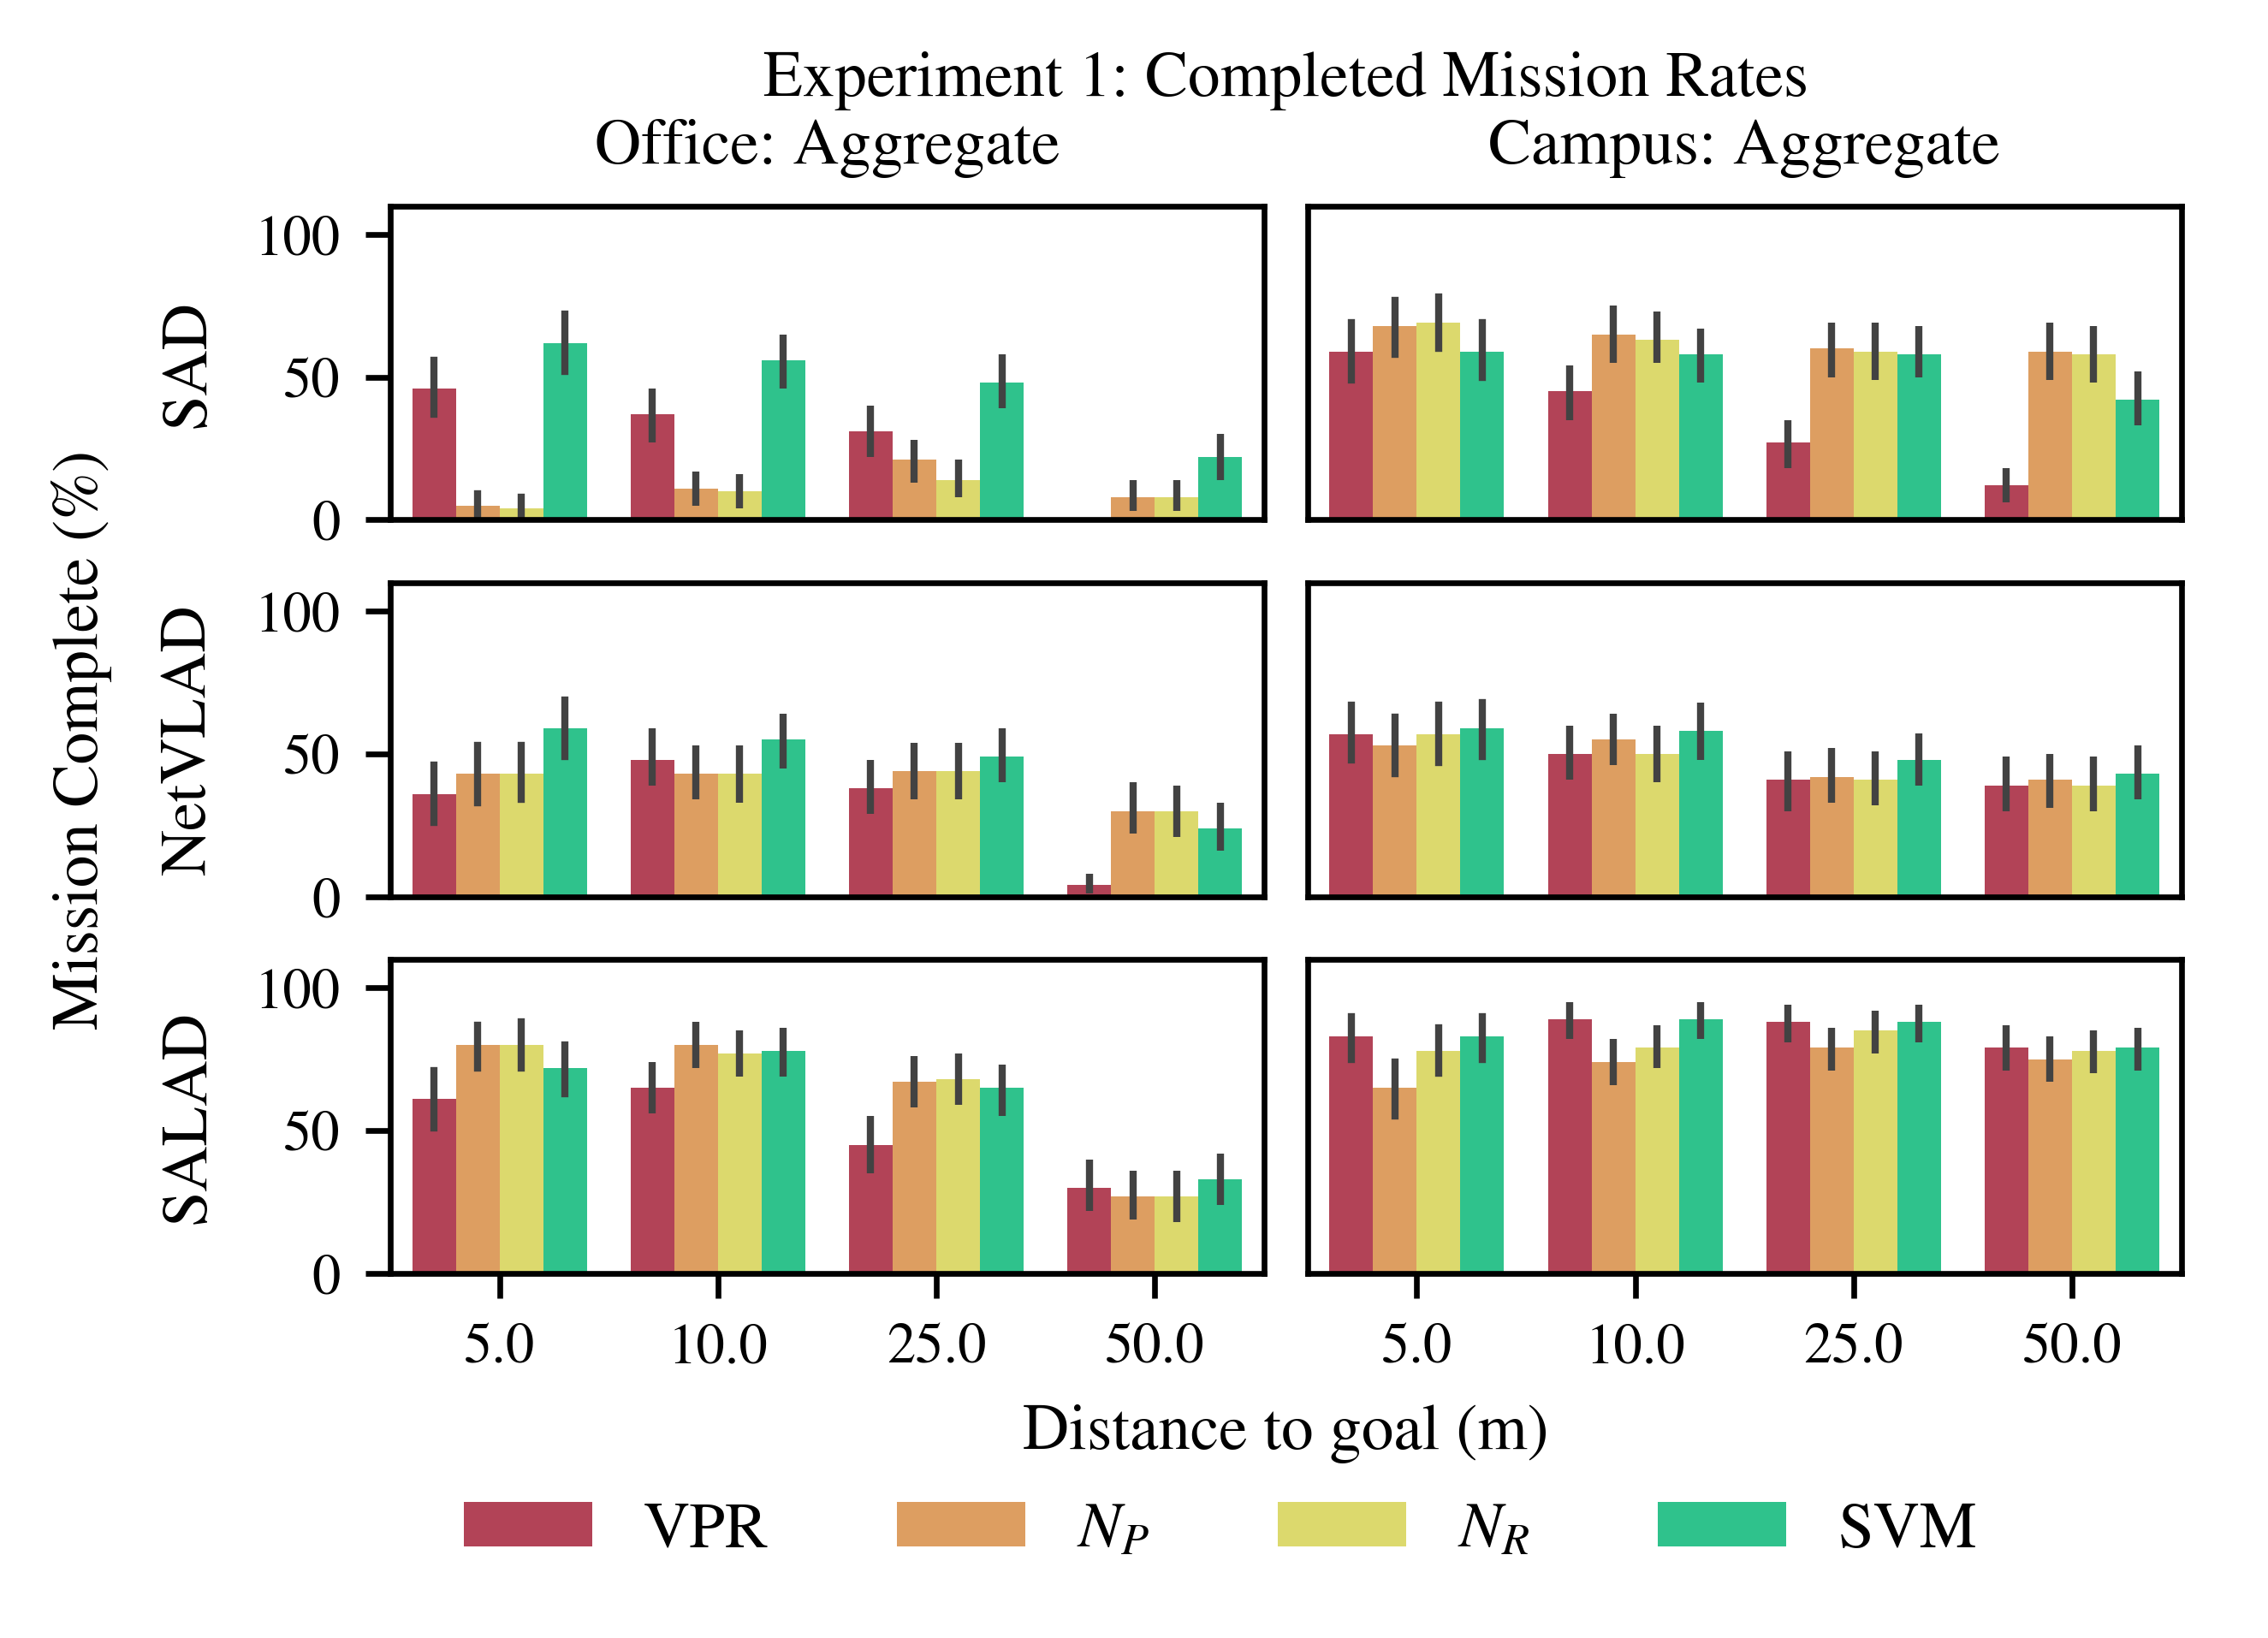

In [69]:
if True: # for code folding :-)
    palette='viridis'

    _s = 4.5/4.0
    err_kws={"linestyle": '-'}
    fig,ax=plt.subplots(3,2,figsize=(4*_s,_s*0.8*3),sharex=True,sharey=True)

    barplotter = lambda _env, _ft_type, _ax: sns.barplot(data=df_features[(df_features.environment==_env) & (df_features.vprfeaturetype==_ft_type) & (df_features.mission_impossible==False)],
                x='slice_length',y='mission_complete',hue='filter',palette=_palette,ax=_ax,hue_order=hue_order,
                errorbar=("ci",95), linewidth=0.1, width=0.8)

    f00 = barplotter('Lab',    'RAW',       ax[0][0])
    f01 = barplotter('Lab',    'NETVLAD',   ax[1][0])
    f02 = barplotter('Lab',    'SALAD',     ax[2][0])

    f10 = barplotter('Campus', 'RAW',       ax[0][1])
    f11 = barplotter('Campus', 'NETVLAD',   ax[1][1])
    f12 = barplotter('Campus', 'SALAD',     ax[2][1])

    ax[0][0].set_title('Office: Aggregate', fontsize=9)
    ax[0][1].set_title('Campus: Aggregate', fontsize=9)

    ax[0][0].set_ylabel('SAD',     fontsize=9, labelpad=5)
    ax[1][0].set_ylabel('NetVLAD', fontsize=9, labelpad=5)
    ax[2][0].set_ylabel('SALAD',   fontsize=9, labelpad=5)
    ax[0][1].set_ylabel('')
    ax[1][1].set_ylabel('')
    ax[2][1].set_ylabel('')

    fs = [f00, f10, f01, f11, f02, f12]

    # [i.set(xlabel=None,ylim=(0,1),yticks=[0,0.25,0.5,0.75,1.0],yticklabels=[0,25,50,75,100]) for i in fs]
    [i.set(xlabel=None,ylim=(0,1.1),yticks=[0,0.5,1.0],yticklabels=[0,50,100]) for i in fs]
    [i.tick_params(bottom=False) for i in fs[0:-2]]
    [i.tick_params(left=False) for i in fs[1::2]]
    [i.set_xlabel('') for i in fs]
    [i.tick_params(axis='both', which='both', labelsize=8) for i in fs]
    [i.legend_.remove() for i in fs[:-1]]

    for f in fig.get_children():
        for i in f.get_children():
            if isinstance(i, matplotlib.lines.Line2D):
                i._dash_pattern = (0.0, None)
                i._linewidth = 1
                
    _fontdict={"fontsize":9}
    big_frame = fig.add_subplot(111, frameon=False)
    big_frame.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_frame.set_ylabel('Mission Complete (%)',  labelpad=22, fontdict=_fontdict)
    big_frame.set_xlabel('Distance to goal (m)',  labelpad=4, fontdict=_fontdict)
    big_frame.set_title('Experiment 1: Completed Mission Rates\n', fontdict=_fontdict)

    legend1=ax[2][1].legend(loc='lower center', bbox_to_anchor=(-0.1, -1.1),ncols=4, frameon=False,title='', fontsize=9)
                        #labels=['No Filter','SVM','Naive Threshold (match P)','Naive Threshold (match R)'])

    fig.subplots_adjust(wspace=0.05)

    fig.canvas.draw()

    path = 'media/exp1_extended_mission_complete_vertical' #relative to file directory
    fig.savefig(path+'.pdf', format='pdf', bbox_extra_artists=(legend1,), dpi=1000, pad_inches=0, bbox_inches='tight')
    fig.savefig(path+'.png', format='png', bbox_extra_artists=(legend1,), dpi=1000, pad_inches=0, bbox_inches='tight')


## Tables

In [70]:
df_features[(df_features.goal_found==True) & (df_features.vprfeaturetype == 'RAW')].groupby(['condition','filter']).abs_overshoot.describe()

count       mean        std       min       25%  \
condition      filter                                                    
Campus Adverse $N_P$   200.0   1.871338   6.228312  0.000231  0.149198   
               $N_R$   200.0   2.571074   7.287530  0.000231  0.154787   
               SVM     196.0   5.767279  11.502378  0.000231  0.278027   
               VPR     200.0  14.516486  17.625120  0.013047  0.309714   
Campus Normal  $N_P$   200.0   8.366731  13.201067  0.010114  0.383346   
               $N_R$   200.0   8.402118  13.224921  0.010114  0.390975   
               SVM     199.0   2.613007   7.399947  0.010114  0.310476   
               VPR     200.0  12.522060  14.855006  0.010114  0.558093   
Lab Adverse    $N_P$    31.0   3.816795   2.501842  0.114758  1.192891   
               $N_R$    31.0   3.816795   2.501842  0.114758  1.192891   
               SVM     200.0   9.044877  11.398347  0.005340  2.802040   
               VPR     200.0  18.603635  14.673744  0.164811  4.983848   
Lab Normal     $N_P$   200.0   3.917094   3.551171  0.006220  0.662879   
               $N_R$   200.0   4.098987   3.471257  0.006220  1.055387   
               SVM     200.0   0.283016   0.287158  0.003845  0.089418   
               VPR     200.0  12.539776  18.748621  0.008832  0.116373   

                             50%        75%        max  
condition      filter                                   
Campus Adverse $N_P$    0.356375   0.729644  49.995620  
               $N_R$    0.369172   0.858363  50.079879  
               SVM      0.776400   2.992167  48.632053  
               VPR      5.029035  24.975485  50.079879  
Campus Normal  $N_P$    1.293980   9.961284  50.043183  
               $N_R$    1.274223   9.961284  50.043183  
               SVM      0.791293   1.901615  50.043183  
               VPR      5.783999  22.362288  50.047370  
Lab Adverse    $N_P$    4.223938   5.788708   7.828217  
               $N_R$    4.223938   5.788708   7.828217  
               SVM      4.310154  10.930871  50.016650  
               VPR     14.377354  27.524615  50.031321  
Lab Normal     $N_P$    3.001354   6.056117  13.528224  
               $N_R$    3.299338   6.080617  13.621532  
               SVM      0.182820   0.422994   1.936342  
               VPR      0.346786  24.565550  50.020707

In [71]:
df_features['mission_failed'] = df_features.mission_complete == False
print(df_features[(df_features.goal_found==True)].groupby(['filter']).mission_complete.sum())
print(df_features[(df_features.goal_found==True)].groupby(['filter']).mission_failed.sum())


filter
$N_P$    1195
$N_R$    1204
SVM      1387
VPR      1110
Name: mission_complete, dtype: int64
filter
$N_P$    1033
$N_R$    1027
SVM       995
VPR      1290
Name: mission_failed, dtype: int64


In [72]:
df_features[(df_features.goal_found==True)].groupby(['vprfeaturetype','filter']).abs_overshoot.describe()

count       mean        std       min       25%  \
vprfeaturetype filter                                                    
NETVLAD        $N_P$   797.0   6.541461  12.304075  0.000173  0.258984   
               $N_R$   800.0   7.440346  13.448672  0.000173  0.258260   
               SVM     787.0   5.791030  12.164701  0.000173  0.217922   
               VPR     800.0  12.673100  17.222681  0.000173  0.288598   
RAW            $N_P$   631.0   4.674094   8.866906  0.000231  0.272879   
               $N_R$   631.0   4.964749   9.055277  0.000231  0.306375   
               SVM     795.0   4.422583   9.470826  0.000231  0.215881   
               VPR     800.0  14.545489  16.723036  0.008832  0.391238   
SALAD          $N_P$   800.0   2.113922   6.310990  0.000913  0.150182   
               $N_R$   800.0   1.887618   6.168845  0.000913  0.149278   
               SVM     800.0   1.890993   6.316381  0.000913  0.150341   
               VPR     800.0   3.556632   9.318464  0.000913  0.150182   

                            50%        75%        max  
vprfeaturetype filter                                  
NETVLAD        $N_P$   1.259316   4.982779  50.048247  
               $N_R$   1.402003   6.312126  50.062755  
               SVM     0.746784   3.305101  50.051782  
               VPR     4.105181  24.427754  50.062755  
RAW            $N_P$   1.003419   5.225799  50.043183  
               $N_R$   1.196861   5.737060  50.079879  
               SVM     0.687962   3.237234  50.043183  
               VPR     6.922924  24.922770  50.079879  
SALAD          $N_P$   0.355192   1.226232  50.065360  
               $N_R$   0.329805   0.863947  50.065360  
               SVM     0.324602   0.781458  50.065360  
               VPR     0.369468   1.265203  50.065360

In [73]:
if True: # for code folding :-)
    LATEX_MODE = True

    if LATEX_MODE:
        _sb = r'\B{'
        _sn = r''
        _eb = r'm}'
        _en = r'm '
        _ebp = r'\%%}'
        _enp = r'\%% '
        _ee = r' \\'
        _sf = '& % 13s '
    else:
        _sb = r'  '
        _sn = r''
        _eb = r'm*'
        _en = r'm '
        _ebp = r'%%*'
        _enp = r'%% '
        _ee = r'   '
        _sf = ' % 13s |'
    print()
    df_ = df_features[(df_features.mission_impossible==False)]
    for featname, feat in zip(['SAD', 'NetVLAD', 'SALAD'], ['RAW', 'NETVLAD', 'SALAD']):
        
        if LATEX_MODE:
            if feat != 'RAW':
                print(r'    \hline')
            else:
                print(r'    \cline{3-6}')
            print(r'    & & \multicolumn{4}{c|}{\B{' + featname + r' Features}} \\')
            if feat == 'RAW':
                print(r'    & & \B{Baseline} & \multicolumn{3}{c|}{\B{Filtering Technique}} \\')
                print(r'    & & \B{VPR}      & \boldmath{$N_P$} & \boldmath{$N_R$} & \B{Ours} \\')
            print(r'    \hline')
        else:
            print('\n' + featname)
        for env, envAdj in zip(['Office', 'Campus', 'Aggregate'], ['Lab', 'Campus', 'Aggregate']):
            if (feat != 'RAW'):
                if (env != 'Aggregate'):
                    continue
            for cond in ['Normal', 'Adverse']:
                if (env == 'Aggregate'): 
                    if (cond == 'Adverse'): break
                    else: 
                        set_name = env
                else:
                    set_name = env + ' ' + cond
                    setAdj_name = envAdj + ' ' + cond
                mean_strs = []
                medi_strs = []
                max__strs = []
                if not (set_name == 'Aggregate'):
                    df__ = df_[(df_['condition'] == setAdj_name) & (df_['vprfeaturetype']==feat)]
                else:
                    df__ = df_[(df_['vprfeaturetype']==feat)]
                    
                vpr_data = df__[df__['filter']=='VPR']
                svm_data = df__[df__['filter']=='SVM']
                nvp_data = df__[df__['filter']=='$N_P$']
                nvr_data = df__[df__['filter']=='$N_R$']

                gf___vpr = 100 * vpr_data[vpr_data.goal_found==True].shape[0] / len(vpr_data)
                mean_vpr = np.nanmean(      vpr_data.abs_overshoot[vpr_data.goal_found==True])
                medi_vpr = np.nanmedian(    vpr_data.abs_overshoot[vpr_data.goal_found==True])
                max__vpr = np.nanpercentile(vpr_data.abs_overshoot[vpr_data.goal_found==True], [100])[0]

                gf___svm = 100 * svm_data[svm_data.goal_found==True].shape[0] / len(svm_data)
                mean_svm = np.nanmean(      svm_data.abs_overshoot[svm_data.goal_found==True])
                medi_svm = np.nanmedian(    svm_data.abs_overshoot[svm_data.goal_found==True])
                max__svm = np.nanpercentile(svm_data.abs_overshoot[svm_data.goal_found==True], [100])[0]

                gf___nvp = 100 * nvp_data[nvp_data.goal_found==True].shape[0] / len(nvp_data)
                mean_nvp = np.nanmean(      nvp_data.abs_overshoot[nvp_data.goal_found==True])
                medi_nvp = np.nanmedian(    nvp_data.abs_overshoot[nvp_data.goal_found==True])
                max__nvp = np.nanpercentile(nvp_data.abs_overshoot[nvp_data.goal_found==True], [100])[0]

                gf___nvr = 100 * nvr_data[nvr_data.goal_found==True].shape[0] / len(nvr_data)
                mean_nvr = np.nanmean(      nvr_data.abs_overshoot[nvr_data.goal_found==True])
                medi_nvr = np.nanmedian(    nvr_data.abs_overshoot[nvr_data.goal_found==True])
                max__nvr = np.nanpercentile(nvr_data.abs_overshoot[nvr_data.goal_found==True], [100])[0]

                gf__s = np.round(np.array([gf___vpr, gf___nvp, gf___nvr, gf___svm]),2)
                gf___max = list(np.where(gf__s == gf__s.max())[0])
                gf___str = ''.join([_sf % (((_sb if i in gf___max else _sn) + '%3.2f' + (_ebp if i in gf___max else _enp)) % gf__s[i]) for i in range(4)])

                means = np.round(np.array([mean_vpr, mean_nvp, mean_nvr, mean_svm]),2)
                mean_min = list(np.where(means == means.min())[0])
                mean_str = ''.join([_sf % (((_sb if i in mean_min else _sn) + '%3.2f' + (_eb if i in mean_min else _en)) % means[i]) for i in range(4)])

                medis = np.round(np.array([medi_vpr, medi_nvp, medi_nvr, medi_svm]),2)
                medi_min = list(np.where(medis == medis.min())[0])
                medi_str = ''.join([_sf % (((_sb if i in medi_min else _sn) + '%3.2f' + (_eb if i in medi_min else _en)) % medis[i]) for i in range(4)])

                max_s = np.round(np.array([max__vpr, max__nvp, max__nvr, max__svm]),2)
                max__min = list(np.where(max_s == max_s.min())[0])
                max__str = ''.join([_sf % (((_sb if i in max__min else _sn) + '%3.2f' + (_eb if i in max__min else _en)) % max_s[i]) for i in range(4)])

                _set_name = set_name.replace('\n',' ')
                if not LATEX_MODE:
                    print(_set_name)
                    print((' '*7) + ''.join(['% 16s' % i for i in ['VPR', 'NVP', 'NVR', 'SVM']]))
                if LATEX_MODE:
                    _first_whole = r'\ocMCSMR{1}{|c|}{4}{' + _set_name + r'}' + (' '*5 if env == 'Aggregate' else (' ' if cond == 'Normal' else ''))
                    _other = r'\ocblb'
                    _other_whole = _other + (' ' * (len(_first_whole) - len(_other)))
                    print('    ' + _first_whole + ' & G.F. ' + gf___str + _ee)
                    print('    ' + _other_whole + ' & Mean ' + mean_str + _ee)
                    print('    ' + _other_whole + ' & Med. ' + medi_str + _ee)
                    print('    ' + _other_whole + ' & Max. ' + max__str + _ee)
                    if env != 'Aggregate':
                        print('    \hline')
                else:
                    print('Goal Found ' + gf___str)
                    print('      Mean ' + mean_str)
                    print('      Med. ' + medi_str)
                    print('      Max. ' + max__str)
    if LATEX_MODE:
        print('    \hline')


    \cline{3-6}
    & & \multicolumn{4}{c|}{\B{SAD Features}} \\
    & & \B{Baseline} & \multicolumn{3}{c|}{\B{Filtering Technique}} \\
    & & \B{VPR}      & \boldmath{$N_P$} & \boldmath{$N_R$} & \B{Ours} \\
    \hline
    \ocMCSMR{1}{|c|}{4}{Office Normal}  & G.F. &  \B{100.00\%} &  \B{100.00\%} &  \B{100.00\%} &  \B{100.00\%}  \\
    \ocblb                              & Mean &       12.54m  &        3.92m  &        4.10m  &     \B{0.28m}  \\
    \ocblb                              & Med. &        0.35m  &        3.00m  &        3.30m  &     \B{0.18m}  \\
    \ocblb                              & Max. &       50.02m  &       13.53m  &       13.62m  &     \B{1.94m}  \\
    \hline
    \ocMCSMR{1}{|c|}{4}{Office Adverse} & G.F. &  \B{100.00\%} &      15.50\%  &      15.50\%  &  \B{100.00\%}  \\
    \ocblb                              & Mean &       18.60m  &     \B{3.82m} &     \B{3.82m} &        9.04m   \\
    \ocblb                              & Med. &       14.38m  &     \B{4.22m}

In [74]:
if False: # for code folding
    LATEX_MODE = True

    if LATEX_MODE:
        _sb = r'\B{'
        _sn = r''
        _eb = r'm}'
        _en = r'm '
        _ebp = r'\%%}'
        _enp = r'\%% '
        _ee = r' \\'
        _sf = '& % 13s '
    else:
        _sb = r'  '
        _sn = r''
        _eb = r'm*'
        _en = r'm '
        _ebp = r'%%*'
        _enp = r'%% '
        _ee = r'   '
        _sf = ' % 13s |'
    print()
    df_ = df_features[(df_features.mission_impossible==False)]
    for featname, feat in zip(['SAD', 'NetVLAD', 'SALAD'], ['RAW', 'NETVLAD', 'SALAD']):
        
        if LATEX_MODE:
            if feat != 'RAW':
                print(r'    \hline')
            else:
                print(r'    \cline{3-6}')
            print(r'    & & \multicolumn{4}{c|}{\B{' + featname + r' Features}} \\')
            if feat == 'RAW':
                print(r'    & & \B{Baseline} & \multicolumn{3}{c|}{\B{Filtering Technique}} \\')
                print(r'    & & \B{VPR}      & \boldmath{$N_P$} & \boldmath{$N_R$} & \B{Ours} \\')
            print(r'    \hline')
        else:
            print('\n' + featname)
        for env, envAdj in zip(['Office', 'Campus', 'Aggregate'], ['Lab', 'Campus', 'Aggregate']):
            if (feat != 'RAW'):
                if (env != 'Aggregate'):
                    continue
            for cond in ['Normal', 'Adverse']:
                if (env == 'Aggregate'): 
                    if (cond == 'Adverse'): break
                    else: 
                        set_name = env
                else:
                    set_name = env + ' ' + cond
                    setAdj_name = envAdj + ' ' + cond
                mean_strs = []
                medi_strs = []
                max__strs = []
                if not (set_name == 'Aggregate'):
                    df__ = df_[(df_['condition'] == setAdj_name) & (df_['vprfeaturetype']==feat)]
                else:
                    df__ = df_[(df_['vprfeaturetype']==feat)]
                    
                vpr_data = df__[df__['filter']=='VPR']
                svm_data = df__[df__['filter']=='SVM']
                nvp_data = df__[df__['filter']=='$N_P$']
                nvr_data = df__[df__['filter']=='$N_R$']

                gf___vpr = 100 * vpr_data[vpr_data.mission_complete==True].shape[0] / len(vpr_data)
                mean_vpr = np.nanmean(      vpr_data.abs_overshoot[vpr_data.goal_found==True])
                medi_vpr = np.nanmedian(    vpr_data.abs_overshoot[vpr_data.goal_found==True])
                max__vpr = np.nanpercentile(vpr_data.abs_overshoot[vpr_data.goal_found==True], [100])[0]

                gf___svm = 100 * svm_data[svm_data.mission_complete==True].shape[0] / len(svm_data)
                mean_svm = np.nanmean(      svm_data.abs_overshoot[svm_data.goal_found==True])
                medi_svm = np.nanmedian(    svm_data.abs_overshoot[svm_data.goal_found==True])
                max__svm = np.nanpercentile(svm_data.abs_overshoot[svm_data.goal_found==True], [100])[0]

                gf___nvp = 100 * nvp_data[nvp_data.mission_complete==True].shape[0] / len(nvp_data)
                mean_nvp = np.nanmean(      nvp_data.abs_overshoot[nvp_data.goal_found==True])
                medi_nvp = np.nanmedian(    nvp_data.abs_overshoot[nvp_data.goal_found==True])
                max__nvp = np.nanpercentile(nvp_data.abs_overshoot[nvp_data.goal_found==True], [100])[0]

                gf___nvr = 100 * nvr_data[nvr_data.mission_complete==True].shape[0] / len(nvr_data)
                mean_nvr = np.nanmean(      nvr_data.abs_overshoot[nvr_data.goal_found==True])
                medi_nvr = np.nanmedian(    nvr_data.abs_overshoot[nvr_data.goal_found==True])
                max__nvr = np.nanpercentile(nvr_data.abs_overshoot[nvr_data.goal_found==True], [100])[0]

                gf__s = np.round(np.array([gf___vpr, gf___nvp, gf___nvr, gf___svm]),2)
                gf___max = list(np.where(gf__s == gf__s.max())[0])
                gf___str = ''.join([_sf % (((_sb if i in gf___max else _sn) + '%3.2f' + (_ebp if i in gf___max else _enp)) % gf__s[i]) for i in range(4)])

                means = np.round(np.array([mean_vpr, mean_nvp, mean_nvr, mean_svm]),2)
                mean_min = list(np.where(means == means.min())[0])
                mean_str = ''.join([_sf % (((_sb if i in mean_min else _sn) + '%3.2f' + (_eb if i in mean_min else _en)) % means[i]) for i in range(4)])

                medis = np.round(np.array([medi_vpr, medi_nvp, medi_nvr, medi_svm]),2)
                medi_min = list(np.where(medis == medis.min())[0])
                medi_str = ''.join([_sf % (((_sb if i in medi_min else _sn) + '%3.2f' + (_eb if i in medi_min else _en)) % medis[i]) for i in range(4)])

                max_s = np.round(np.array([max__vpr, max__nvp, max__nvr, max__svm]),2)
                max__min = list(np.where(max_s == max_s.min())[0])
                max__str = ''.join([_sf % (((_sb if i in max__min else _sn) + '%3.2f' + (_eb if i in max__min else _en)) % max_s[i]) for i in range(4)])

                _set_name = set_name.replace('\n',' ')
                if not LATEX_MODE:
                    print(_set_name)
                    print((' '*2) + ''.join(['% 13s' % i for i in ['VPR', 'NVP', 'NVR', 'SVM']]))
                if LATEX_MODE:
                    _first_whole = r'\ocMCSMR{1}{|c|}{4}{' + _set_name + r'}' + (' '*5 if env == 'Aggregate' else (' ' if cond == 'Normal' else ''))
                    _other = r'\ocblb'
                    _other_whole = _other + (' ' * (len(_first_whole) - len(_other)))
                    print('    ' + _first_whole + ' & M.C. ' + gf___str + _ee)
                    print('    ' + _other_whole + ' & Mean ' + mean_str + _ee)
                    print('    ' + _other_whole + ' & Med. ' + medi_str + _ee)
                    print('    ' + _other_whole + ' & Max. ' + max__str + _ee)
                    if env != 'Aggregate':
                        print('    \hline')
                else:
                    print('Mission Complete ' + mean_str)
                    print('            Mean ' + mean_str)
                    print('            Med. ' + medi_str)
                    print('            Max. ' + max__str)
    if LATEX_MODE:
        print('    \hline')